In [1]:
import sys
sys.path.append('../')

import copy

from tasks import LauraTaskWrapper
from architecture import SequentialModel
from analysis_utils import load_checkpoints, import_checkpoint
from train import ping_dir
# from analysis.parameter_op import ParameterOperator
from analysis.parameter_op_general import ParameterOperator
from analysis.propagation_op_general import PropagationOperator_DirectForm, PropagationOperator_LinearForm
from analysis.op_common import ComposedOperator, TransposedOperator, AveragedOperator, FinalTimestepOperator
from scipy.sparse.linalg import eigsh

def running_mean(arr, axis, window_size=5):
    return np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='valid'), axis, arr)

def running_var(arr, axis, window_size=5):
    return running_mean(arr**2, axis, window_size) - running_mean(arr, axis, window_size)**2

def plot_smooth(x, y, window_size, axis = 0, var_scale = 0, fill_kwargs = {}, **plot_kwargs):
    mu_x, mu_y = running_mean(x, axis, window_size), running_mean(y, axis, window_size)
    var_y = running_var(y, axis, window_size)
    plt.plot(mu_x, mu_y, **plot_kwargs)
    if var_scale != 0:
        plt.fill_between(mu_x, mu_y - var_scale * var_y, mu_y + var_scale * var_y, **fill_kwargs)

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14
BIGGEST_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE) # fontsize of the figure title

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    
})

PALLETTE = ['#f86969ff', '#7e69f8ff', '#f8c969ff', '#69f87cff', '#e569f8ff']


torch_to_np = lambda x: x.detach().cpu().numpy() if torch.is_tensor(x) else x
np_to_torch = lambda x: torch.from_numpy(x) if not torch.is_tensor(x) else x

def absolute_error(x, y):
    return np.abs(torch_to_np(x) - torch_to_np(y)).max()

def relative_error(x, y):
    return absolute_error(x, y) /  max(np.abs(torch_to_np(x)).max(), np.abs(torch_to_np(y)).max())

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(f'<h4>{string}</h4>'))

def printbigmd(string):
    display(Markdown(f'<h2><center style="color:red">{string}</center></h2>'))

def label_axes_with_alphabet(rel_x = -0.05, rel_y = 1.1, **text_kwargs):
    text_kwargs.setdefault('fontsize', BIGGER_SIZE)
    text_kwargs.setdefault('weight', 'bold')
    labels = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    # Loop over each subplot and add the label
    axes = plt.gcf().axes
    assert(len(axes) <= len(labels))
    for i, ax in enumerate(axes):
        # Add label in the top-left corner
        from mpl_toolkits.mplot3d.axes3d import Axes3D
        text_fn = ax.text2D if isinstance(ax, Axes3D) else ax.text
        text_fn(rel_x, rel_y, labels[i], transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right', **text_kwargs)

In [2]:
class Model(nn.Module):
    def __init__(self, input_size=3, hidden_size=100, output_size=3, rnn = nn.GRU, bias = True, nonlinearity='tanh'):
        super().__init__()
        if rnn == nn.RNN:
            self.rnn = rnn(input_size, hidden_size, batch_first=True, bias = bias, nonlinearity = nonlinearity)
        else:
            self.rnn = rnn(input_size, hidden_size, batch_first=True, bias = bias)
        self.Wout = nn.Linear(hidden_size, output_size, bias = bias)
        self.hidden_size = hidden_size
        
    def forward(self, x, h0=None):
        hidden, _ = self.rnn(x, h0)
        return self.Wout(hidden), hidden  # [B, T, 3]
    
    def analysis_mode(self, X, target, h0=None, return_param_grads = False):
        # Intended for deep analysis of the GD flow:
        # Run RNN and compute losses, 
        # returning hidden, adjoints, outputs, unreduced losses, reduced loss.
        # Shapes: [B, T, H], [B, T, H], [B, T, O], [B, T, O], scalar.
        cell = get_cell_from_model(self)
        for param in cell.parameters():
            param.requires_grad_()
            
        hidden = [h0 if h0 is not None else torch.zeros((X.shape[0], self.hidden_size))]
        hidden[0] = hidden[0].to(X.device)
        for t in range(X.shape[1]):
            hidden.append(cell(X[:, t], hidden[-1]).clone())
        hidden = hidden[1:]
        for h in hidden:
            h.requires_grad_()
            h.retain_grad()
        out = self.Wout(torch.stack(hidden, 1)) # [B, T, output_size]
        loss_fn = nn.MSELoss(reduction='none')
        loss_unreduced = loss_fn(out, target)
        loss = loss_unreduced.mean()
        loss.backward()  # Perform BPTT.
        adjoint = torch.stack([h.grad for h in hidden], 1)  # dL/dz defn of adjoint.
        hidden = torch.stack(hidden, 1)

        if return_param_grads:
            param_grads = {}
            for name, param in cell.named_parameters():
                param_grads[name] = param.grad.clone()
            
            return hidden, adjoint, out, loss_unreduced, loss, param_grads
        
        return hidden, adjoint, out, loss_unreduced, loss

# Get a GRUCell from the model above with the same parameters.
def get_cell_from_model(model):
    if isinstance(model.rnn, nn.GRU):
        cell = nn.GRUCell(model.rnn.input_size, model.rnn.hidden_size, bias = model.rnn.bias).to(model.Wout.weight.device)
    else:
        cell = nn.RNNCell(model.rnn.input_size, model.rnn.hidden_size, bias = model.rnn.bias).to(model.Wout.weight.device)
    cell.weight_ih.data.copy_(model.rnn.weight_ih_l0.data)
    cell.weight_hh.data.copy_(model.rnn.weight_hh_l0.data)
    if model.rnn.bias:  
        cell.bias_ih.data.copy_(model.rnn.bias_ih_l0.data)
        cell.bias_hh.data.copy_(model.rnn.bias_hh_l0.data)
    return cell

In [3]:
def get_components(X, k=-1, center = True, return_var = False):
    # If center = True, use PCA. If not true, use SVD, i.e. consider points relative to zero, not the mean.
    if center:
        return PCA(k).fit(X).components_

    # SVD case.
    _, S, Vt = np.linalg.svd(X, full_matrices=False)
    var = S**2 
    varrat = var / np.sum(var)
    dim = np.argwhere(np.cumsum(varrat) > .95)[0,0] + 1
    if k != -1:
        Vt = Vt[:dim]
        var = var[:dim]

    if return_var:
        return dim, Vt, var
    return dim, Vt
    
def unit_vector(vector, axis = -1):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, axis = axis, keepdims = True)

def angle_between(v1, v2, axis = -1):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1, axis)
    v2_u = unit_vector(v2, axis)
    v1t = np.moveaxis(v1_u, axis, -1)
    v2t = np.moveaxis(v2_u, axis, -1)
    dot = (v1t[..., None, :] @ v2t[..., :, None])[..., 0, 0]
    return np.arccos(np.clip(dot, -1.0, 1.0))

def get_operator(op_class, inputs, checkpoint = '', rnn = nn.GRU, hidden_size = 100, scale = 1., model = None):
    device = 'cpu'
    
    if model is None:
        model = Model(rnn = rnn, hidden_size = hidden_size).to(device)
        if checkpoint != '':
            model.load_state_dict(import_checkpoint(checkpoint))

    for name, param in model.named_parameters():
        if name == 'rnn.weight_hh_l0':
            param.data = param.data * scale

    model.rnn.flatten_parameters()

    out, hidden = model(inputs.to(device))
    out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()

    cell = get_cell_from_model(model)
    return op_class(cell, inputs, hidden), hidden

def eval_simple_at_iter(iter, checkpoints, inputs, targets, rnn = nn.GRU, hidden_size = 100):
    model = Model(rnn = rnn, hidden_size = hidden_size)
    model.load_state_dict(import_checkpoint(checkpoints[iter]))
    out = model(inputs)[0]
    return nn.MSELoss()(out, targets).item()

def eval_at_iter(iter, checkpoints, inputs, targets, rnn = nn.GRU, hidden_size = 100, to_np = True, h0 = None):
    model = Model(rnn = rnn, hidden_size = hidden_size)
    if len(checkpoints) > 0:
        model.load_state_dict(import_checkpoint(checkpoints[iter]))
    hidden, adjoint, output, loss_unreduced, loss = model.analysis_mode(inputs, targets, h0=h0)
    if to_np:
        hidden, adjoint, output, loss_unreduced, loss = torch_to_np(hidden), torch_to_np(adjoint), torch_to_np(output), torch_to_np(loss_unreduced), torch_to_np(loss)
    return model, hidden, adjoint, output, loss_unreduced, loss

# Load model and generate testing set:

In [4]:
task_test  = LauraTaskWrapper('memory_pro', 30, use_noise = False, n_samples = 30, n_spike = 20, T = 90)
inputs, targets = task_test()

import glob
sweep_files = glob.glob('mempro_tasks_rnn_256_units_over_scales_4_26_small_sweep/scale_*/')
# sweep_files = glob.glob('mempro_tasks_rnn_256_units_over_scales_5_9_small_sweep_relu/scale_*/')

print(sweep_files[3])
checkpoints = load_checkpoints(sweep_files[3])[0] 

mempro_tasks_rnn_256_units_over_scales_4_26_small_sweep/scale_1.3333333333333333/


## Test PKP^T Gives True Gradient Flow!! Also, spectral analysis of PKP^T.

Relative error of true parameter grads and produced by J_theta^T @ P^*
weight_ih 0.0003978739
weight_hh 0.022062268
bias_ih 0.00036245235
bias_hh 0.00036245235
-------
0.20320387


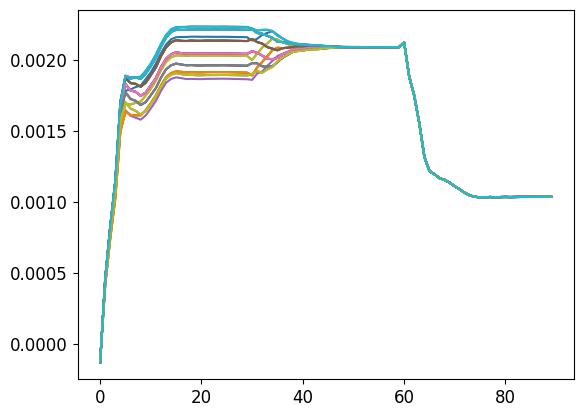

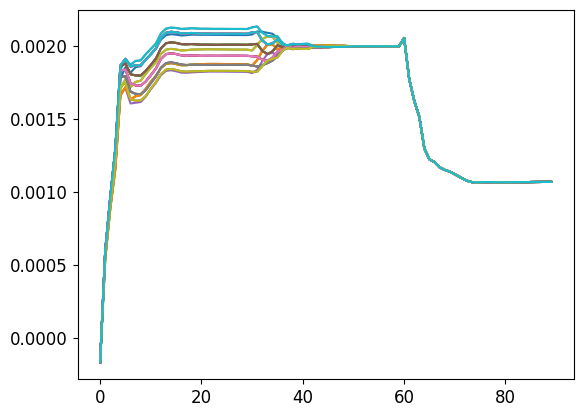

In [5]:
pop = get_operator(PropagationOperator_DirectForm, inputs, checkpoints[0], nn.RNN, 256)[0]
kop = get_operator(ParameterOperator, inputs, checkpoints[0], nn.RNN, 256)[0]
jop = kop.jtheta_op

model = Model(rnn = nn.RNN, hidden_size = 256)
model.load_state_dict(import_checkpoint(checkpoints[0]))
hidden, adjoint, output, loss_unreduced, loss, param_grads = model.analysis_mode(inputs, targets, return_param_grads=True)

# Do a small GD perturbation to internal parameters (not Wout) and re-run model. Wout change won't affect hidden state. 
for name, param in model.rnn.named_parameters():
    param = param.detach()
    param.data -= 1e-2 * param_grads[name.replace('_l0', '')]

hidden_after_GD = model(inputs)[1]
true_hidden_diff = hidden_after_GD - hidden

gradop = pop @ kop @ pop.T()
hidden = hidden.detach()
hidden.requires_grad_()
err = torch.autograd.grad(nn.MSELoss()(model.Wout(hidden), targets), hidden)[0] # Residual signal to seed adjoint backprop.
guess_hidden_diff = -1e-2 * gradop(err)
guess_dtheta = (jop.T() @ pop.T())(err)
true_dtheta = {name: param_grads[name.replace('_l0', '')] for name in guess_dtheta.keys()}

print('Relative error of true parameter grads and produced by J_theta^T @ P^*')
for name in guess_dtheta.keys():
    print(name, relative_error(true_dtheta[name], guess_dtheta[name]))

print('-------')

print(relative_error(true_hidden_diff, guess_hidden_diff))

plt.plot(true_hidden_diff[:, :, 0].detach().numpy().T)
plt.show()
plt.plot(guess_hidden_diff[:, :, 0].T)
plt.show()

In [42]:
avg_shape = (hidden.shape[0], hidden.shape[1], 1)
singular_vals_all = []
singular_vecs_all = []

for ch in [checkpoints[0], checkpoints[-1]]:
    model = Model(rnn = nn.RNN, hidden_size = 256, bias = True)
    model.load_state_dict(import_checkpoint(ch))

    pop = get_operator(PropagationOperator_DirectForm, inputs, model = model)[0]
    avg_pop = AveragedOperator(pop @ pop.T(), hidden.shape)
    avg_pop_sp = avg_pop.to_scipy(avg_shape, avg_shape, dtype = float, can_matmat=False)

    singular_vals, singular_vecs = eigsh(avg_pop_sp, k = hidden.shape[1]-1, return_eigenvectors = True, tol = 1e-2)
    singular_vals_all.append(singular_vals[::-1]) # Correctly order the singular values
    singular_vecs_all.append(singular_vecs[:, ::-1].T.reshape((-1, *avg_shape)))

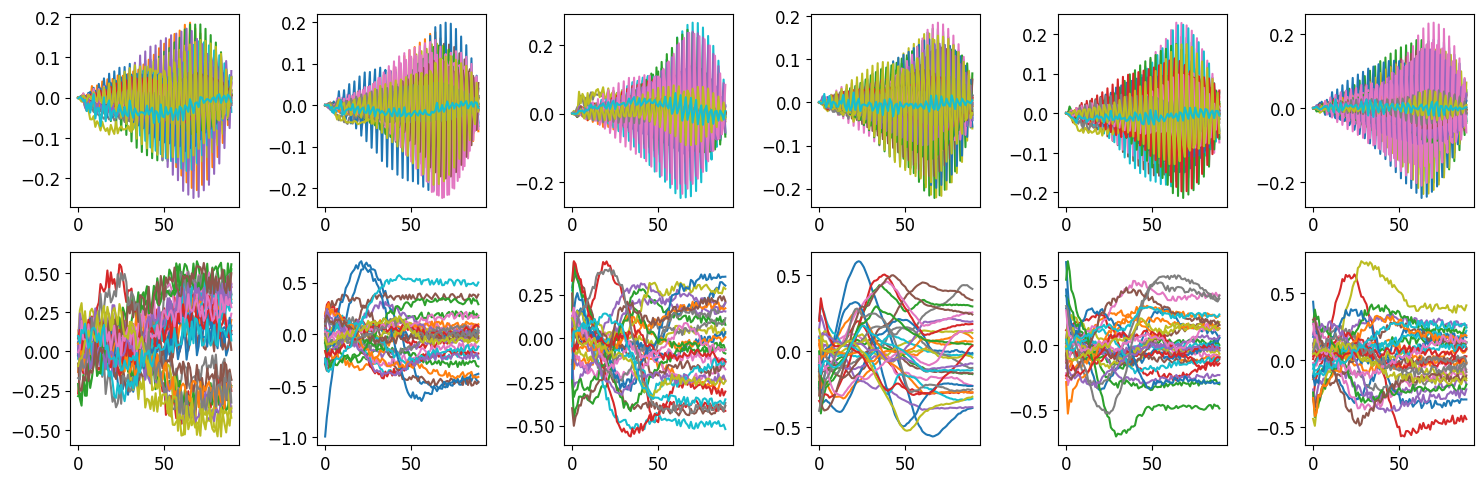

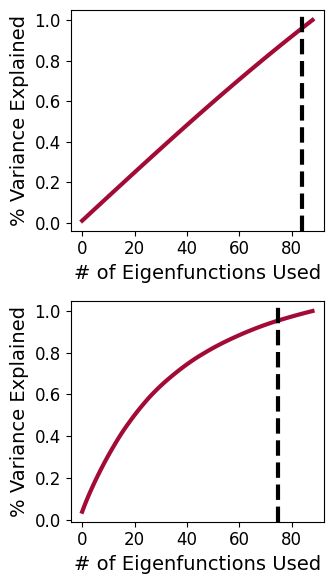

In [44]:
plt.figure(figsize = (6 * 2.5, 2 * 2.5))
for idx, (singular_vals, singular_vecs) in enumerate(zip(singular_vals_all, singular_vecs_all)):
    for i in range(6):
        plt.subplot(2,6,i+1+idx*6)
        plt.plot(singular_vals[i] * singular_vecs[i, :, :, 0].T)
plt.tight_layout()
plt.savefig('P_eigfuns.pdf')
plt.show()

plt.figure(figsize = (3.5,6))
for idx, (singular_vals, singular_vecs) in enumerate(zip(singular_vals_all, singular_vecs_all)):
    plt.subplot(2,1,1+idx)
    effrank, varrat = pop.effrank(singular_vals, .95)
    plt.plot(varrat, color = '#A30B37', linewidth = 3)
    plt.axvline(effrank, c = 'black', linestyle = 'dashed', linewidth = 3)
    plt.xlabel('# of Eigenfunctions Used')
    plt.ylabel('% Variance Explained')

plt.tight_layout()
plt.savefig('explained_vars_P.pdf')
plt.show()

In [71]:
avg_shape = (1, hidden.shape[1], 1)
singular_vals_all = []

model = Model(rnn = nn.RNN, hidden_size = 256, bias = True)
model.load_state_dict(import_checkpoint(checkpoints[-1]))

pop = get_operator(PropagationOperator_DirectForm, inputs, model = model)[0]
kop = get_operator(ParameterOperator, inputs, model = model)[0]

for op in [kop, pop @ pop.T(), pop @ kop @ pop.T()]:
    avg_gradop = AveragedOperator(op, hidden.shape)
    avg_gradop_pop_sp = avg_gradop.to_scipy(avg_shape, avg_shape, dtype = float, can_matmat=False)

    singular_vals = eigsh(avg_gradop_pop_sp, k = hidden.shape[1]-1, return_eigenvectors = False, tol = 1e-2)
    singular_vals = singular_vals[::-1]
    singular_vals_all.append(singular_vals)

singular_vals_all = np.stack(singular_vals_all)

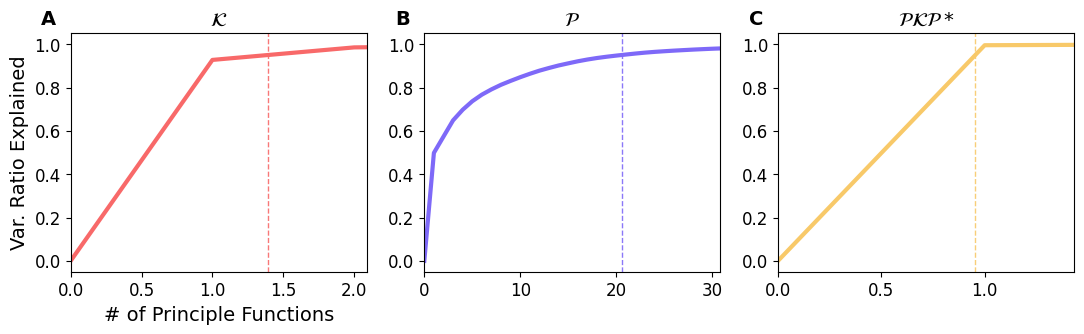

In [72]:
plt.figure(figsize = (11, 3.5))
for i, name in enumerate(['$\\mathcal{K}$', '$\\mathcal{P}$', '$\\mathcal{P K P}*$']):
    plt.subplot(1,3,i+1)
    effdim,varrat = pop.effrank(singular_vals_all[i, :], .95)
    plt.plot(np.concatenate([[0], varrat], axis = 0), color = PALLETTE[i], linewidth = 3)
    plt.axvline(effdim, linewidth = 1, linestyle = 'dashed', color = PALLETTE[i], alpha = .9)
    plt.xlim(0, min(effdim * 1.5, hidden.shape[1]))
    plt.title(name)
    if i == 0:
        plt.xlabel('# of Principle Functions')
        plt.ylabel('Var. Ratio Explained')
plt.tight_layout()
label_axes_with_alphabet()
plt.savefig('compare_effrank.pdf')
plt.show()

In [51]:
avg_shape = (hidden.shape[0], hidden.shape[1], 1)
avg_gradop = AveragedOperator(pop @ kop @ pop.T(), hidden.shape)
avg_gradop_pop_sp = avg_gradop.to_scipy(avg_shape, avg_shape, dtype = float, can_matmat=False)
singular_vals, singular_vecs = eigsh(avg_gradop_pop_sp, k = hidden.shape[1]-1, return_eigenvectors = True, tol = 1e-2)
singular_vals = singular_vals[::-1]
singular_vecs = singular_vecs.T.reshape(-1, hidden.shape[0], hidden.shape[1])[::-1]
scaled_vecs = singular_vals[:, None, None] * singular_vecs

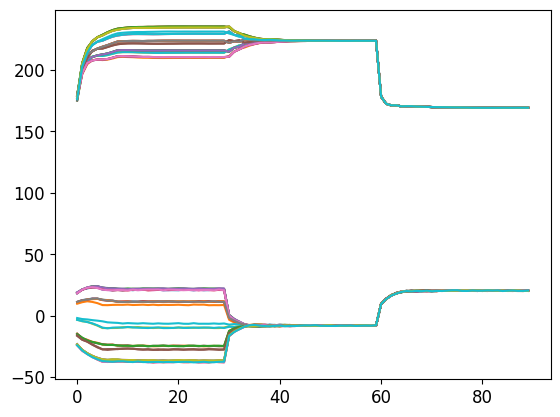

In [52]:
plt.plot(scaled_vecs[0, :, :].T)
plt.plot(scaled_vecs[1, :, :].T)
plt.show()

In [47]:
avg_shape = (hidden.shape[0], hidden.shape[1], 1)
avg_gradop = AveragedOperator(pop @ pop.T(), hidden.shape)
avg_gradop_pop_sp = avg_gradop.to_scipy(avg_shape, avg_shape, dtype = float, can_matmat=False)
singular_vals, singular_vecs = eigsh(avg_gradop_pop_sp, k = hidden.shape[1]-1, return_eigenvectors = True, tol = 1e-2)
singular_vals = singular_vals[::-1]
singular_vecs = singular_vecs.T.reshape(-1, hidden.shape[0], hidden.shape[1])[::-1]
scaled_vecs = singular_vals[:, None, None] * singular_vecs

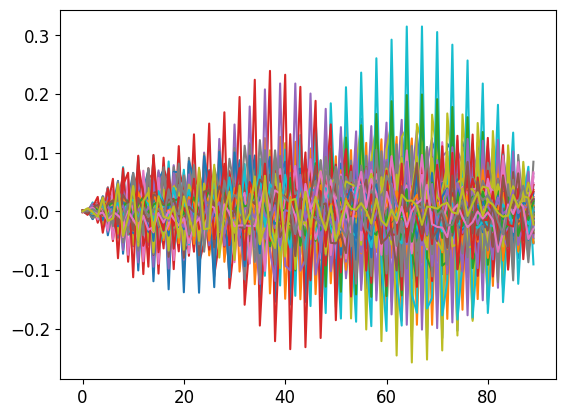

In [49]:
plt.plot(scaled_vecs[:, 0, :].T)
plt.show()

## Test forward and adjoint operator implementation

In [76]:

pops = {'linear': get_operator(PropagationOperator_LinearForm, inputs, checkpoints[0], nn.RNN, 256)[0], 
        # 'gram': get_operator(PropagationGramOperator, inputs, checkpoints[0], nn.RNN, 256)[0],
        'direct': get_operator(PropagationOperator_DirectForm, inputs, checkpoints[0], nn.RNN, 256)[0]}

hidden = get_operator(PropagationOperator_DirectForm, inputs, checkpoints[0], nn.RNN, 256)[1]

In [77]:
model, hidden, adjoint, output = eval_at_iter(0, checkpoints, inputs, targets, nn.RNN, 256)[:4]
hidden_torch = np_to_torch(hidden)
hidden_torch.requires_grad_()

# If operator is correct, P*(Err) should give the true adjoint.
err = torch.autograd.grad(nn.MSELoss()(model.Wout(hidden_torch), targets), hidden_torch)[0] # Residual signal to seed adjoint backprop.

print(relative_error(err[:, -1], adjoint[:, -1]))
print(relative_error(err[:, -2] + (pops['linear'].jacs[:, -1].swapaxes(-2,-1) @ err[:, -1, ..., None])[...,0], adjoint[:, -2]))

guess_err_term = 2 * (model.Wout(hidden_torch) - targets) @ model.Wout.weight / (targets.numel())
print('err term = W_{out}^T (y - y^*) * 2 / k. Relative error of check:', relative_error(guess_err_term, err))

printmd('Adjoint Check:')
for method in ['direct', 'linear']:
    guess_adj = torch_to_np(pops[method].adjoint_call(err))

    print(f'Operator Implementation Method = {method}')
    print("Relative Error:", np.abs(adjoint - guess_adj).max() / max(np.abs(adjoint).max(), np.abs(guess_adj).max()))
    print("Absolute Error:", np.abs(adjoint - guess_adj).max())

0.0
2.2660945e-06
err term = W_{out}^T (y - y^*) * 2 / k. Relative error of check: 1.6739108e-07


<h4>Adjoint Check:</h4>

Operator Implementation Method = direct
Relative Error: 0.0
Absolute Error: 0.0
Operator Implementation Method = linear
Relative Error: 0.008921162
Absolute Error: 4.0629402e-07


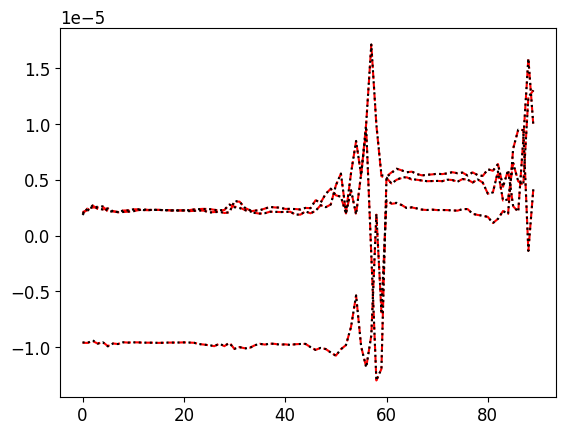

In [78]:
plt.plot(guess_adj[0, :, :3], c = 'red', linestyle = 'dashed')
plt.plot(adjoint[0, :, :3], c = 'black', linestyle = 'dotted')
plt.show()

<h4>Forcing Term Perturbation Check:</h4>

Operator Implementation Method = linear
Relative Error: 0.009837417
Absolute Error: 4.0104496e-06


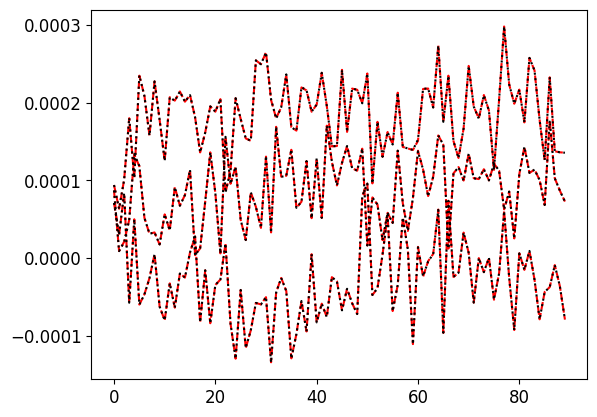

In [79]:
# Perturb forcing term. 
perb = 1e-4 * np.random.rand(*hidden.shape)

true_diff = torch_to_np(pops['direct'](perb))

printmd('Forcing Term Perturbation Check:')

method = 'linear'
guess_diff = pops[method](perb)

print(f'Operator Implementation Method = {method}')
print("Relative Error:", np.abs(true_diff - guess_diff).max() / max(np.abs(true_diff).max(), np.abs(guess_diff).max()))
print("Absolute Error:", np.abs(true_diff - guess_diff).max())

plt.plot(guess_diff[0, :, :3], c = 'red', linestyle = 'dashed')
plt.plot(true_diff[0, :, :3], c = 'black', linestyle = 'dotted')
plt.show()

In [9]:
# Perturb initial condition. 
perb = np.zeros_like(hidden)
perb[:, 0] = 1e-3 * np.random.rand(*perb[:, 0].shape)

h0 = torch.from_numpy(perb[:, 0])

hidden = eval_at_iter(0, checkpoints, inputs, targets, nn.RNN, 256)[1]
hidden_with_perb = eval_at_iter(0, checkpoints, inputs, targets, nn.RNN, 256, h0 = h0)[1]
true_diff = hidden_with_perb - hidden

printmd('Initital Condition Perturbation Check:')
guess_diff = pops['linear'].Us @ torch.from_numpy(perb[:, :1, ..., None])
guess_diff = torch_to_np(guess_diff)[:, 1:, ...,0]

print("Relative Error:", np.abs(true_diff - guess_diff).max() / max(np.abs(true_diff).max(), np.abs(guess_diff).max()))
print("Absolute Error:", np.abs(true_diff - guess_diff).max())

<h4>Initital Condition Perturbation Check:</h4>

Relative Error: 0.025662541
Absolute Error: 4.6952162e-05


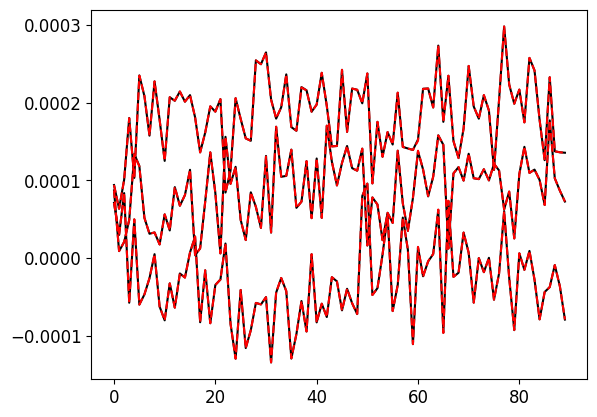

In [80]:
plt.plot(true_diff[0, :, :3], color = 'black', linestyle = 'solid')
plt.plot(guess_diff[0, :, :3], color = 'red', linestyle = 'dashed')

plt.show()

In [7]:
def commutativity_check(inputs, scale, checkpoint = '', rnn = nn.GRU, hidden_size = 100):
    p_pT, hidden = evaluate_prop_gram_op_with_scale(inputs, scale, checkpoint, rnn, hidden_size)
    kop = evaluate_kernel_op_with_scale(inputs, scale, checkpoint, rnn, hidden_size)
    commutator = lambda q: p_pT(kop(q)) - kop(p_pT(q))
    q = np.random.randn(*hidden.shape)
    q = q / np.linalg.norm(q)
    for i in tqdm(range(100)):
        q1 = commutator(q)
        norm_q1 = np.linalg.norm(q1)
        q = q1 / norm_q1
    return norm_q1

# For Re-Training the Model

<h2>For a list of training hyperparameters run 'python train.py --help' or just look in train.py</h2>

<h3> Up to date RNN Data: mempro_tasks_rnn_100_units_over_scales_4_24_try2 </h3>
<h3> Up to date GRU Data: mempro_tasks_gru_100_units_over_scales_4_26 </h3>

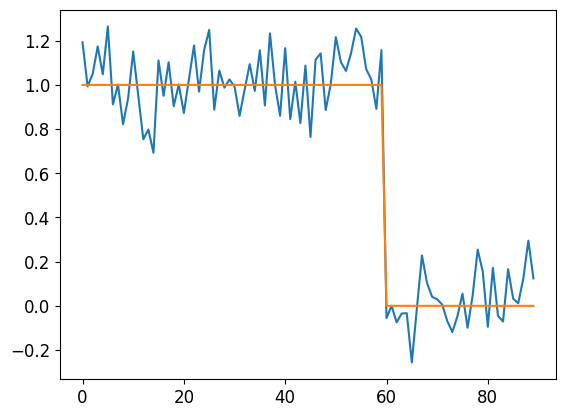

In [60]:
task  = LauraTaskWrapper('memory_pro', 200, use_noise = True, n_samples = 3000, n_spike = 20, T = 90)

inputs, targets = task()
plt.plot(inputs[0, :, 0])
plt.plot(targets[0, :, 0])
plt.show()

            For training with my codebase. I found it to be quite a lot slower than using a vanilla GRU for now so disabled it:

In [6]:
# hyperparams = {
#     'prefix': 'test_mix_tasks_gru',
#     'save_freq': 100,
#     'grad_clip': 0.0001,
#     'lr': 1e-3,
#     'task_suite': 'laura',
#     'task': 'mix_multi_tasks',
#     'niters': 5000
# }

# from train import train
# train(hyperparams)

Vanilla GRU training:

  0%|          | 0/5 [00:00<?, ?it/s]

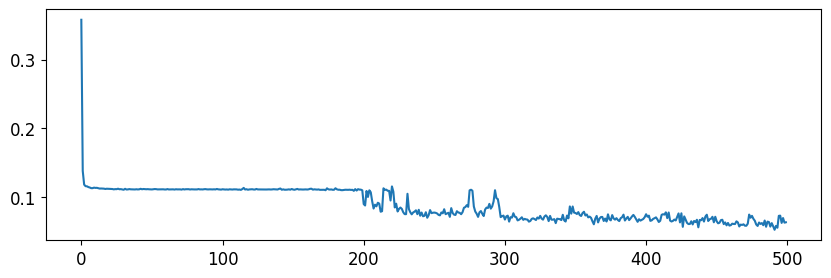

 20%|██        | 1/5 [01:31<06:04, 91.16s/it]

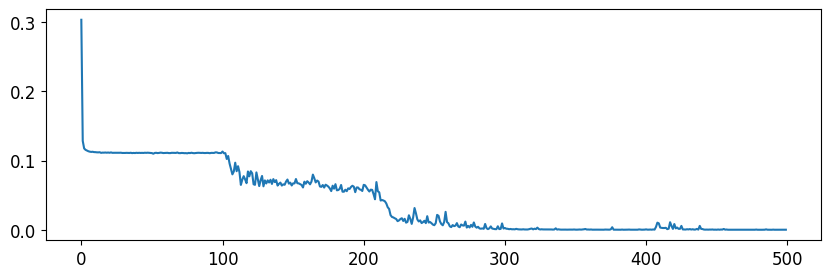

 40%|████      | 2/5 [03:02<04:34, 91.54s/it]

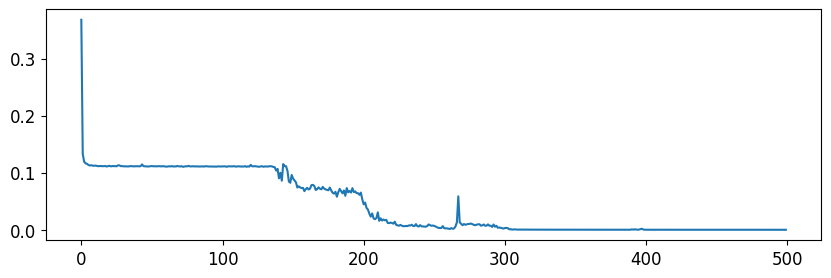

 60%|██████    | 3/5 [04:34<03:03, 91.55s/it]

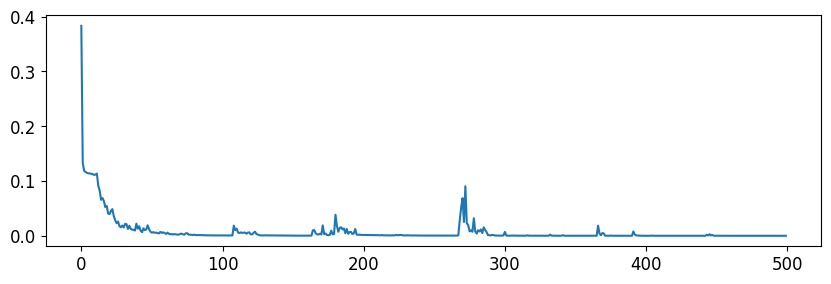

 80%|████████  | 4/5 [06:05<01:31, 91.37s/it]

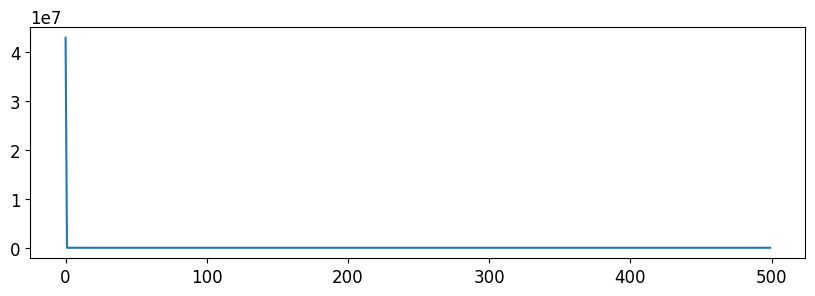

100%|██████████| 5/5 [07:37<00:00, 91.44s/it]


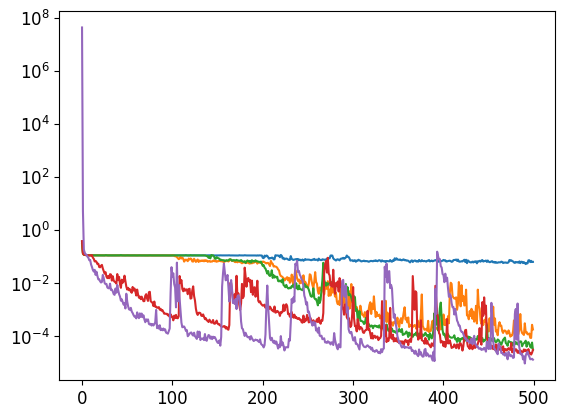

In [62]:
scales = np.linspace(0., 3.0, 5)
#scales = np.linspace(1.0, 1.0, 1)
losses_all = []

# L0 = 0.333

for repeat, scale in enumerate(tqdm(scales)):
    device = 'cuda'

    # Initialize model and move to appropriate device
    model = Model(rnn=nn.RNN, hidden_size = 256, nonlinearity='relu').to(device)
    optim = torch.optim.Adam(model.parameters(), lr = 1e-3) #1000 * 0.05 / 256)
    loss_fn = nn.MSELoss()
    losses = []

    ping_dir('mempro_tasks_rnn_256_units_over_scales_5_9_small_sweep_relu/')
    
    path = f'mempro_tasks_rnn_256_units_over_scales_5_9_small_sweep_relu/scale_{scale}/'
    ping_dir(path)
    ping_dir(f'{path}checkpoints/', clear = True)

    for name, param in model.named_parameters():
        if name == 'rnn.weight_hh_l0':
            param.data = param.data * scale

    model.rnn.flatten_parameters()

    checkpoints = []
    for itr in range(10000):
        inputs, targets = task()
        inputs, targets = inputs.to(device), targets.to(device)  # Instead of .cuda()

        optim.zero_grad()
        out = model(inputs)[0]
        loss = loss_fn(out, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), .0001)
        optim.step()

        # if len(losses) > 2:
        #     if (losses[-1] + loss.item()) / 2. < L0 * 0.05:
        #         break # Converged

        if itr % 20 == 0:
            losses.append(loss.item())

        if itr % 100 == 0:
            checkpoints.append(copy.deepcopy(model.state_dict()))
            torch.save(model.state_dict(), f'{path}checkpoints/checkpoint_{itr}.pt')

    losses_all.append(losses)
    plt.figure(figsize = (10, 3))
    plt.plot(losses)
    plt.show()
 
losses_all = np.array(losses_all)
plt.plot(np.array(losses_all).T)
plt.yscale('log')
plt.show()

In [8]:
# Set noise standard deviation to 0
model.noise_std = 0.

# Make sure to move tensors to CPU for plotting
# This works regardless of whether the tensors are on MPS or CPU device
plt.figure(figsize=(10, 4))
plt.plot(out[0].detach().cpu().numpy(), label='Prediction')
plt.plot(targets[0].detach().cpu().numpy(),':k', label='Target')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Model Prediction')
plt.show()

SyntaxError: '(' was never closed (961255357.py, line 11)

# Consensus SVD of P Final Time Operator

In [19]:
from scipy.sparse.linalg import svds
from analysis.op_common import AveragedOperator

output_shape = (hidden.shape[0], 1, hidden.shape[2])
input_shape = (hidden.shape[0], hidden.shape[1], hidden.shape[2])
final_time_pop = FinalTimestepOperator(pops['direct'], input_shape)

final_time_pop_sp = final_time_pop.to_scipy(input_shape, output_shape, dtype = float, can_matmat=False)

left_singular_vecs_P, singular_vals_P, right_singular_vecs_P = svds(final_time_pop_sp, k = 100, return_singular_vectors = True, tol = 1e-1)
singular_vals_P = singular_vals_P[::-1]

left_singular_vecs_P = left_singular_vecs_P[:, ::-1].T.reshape((-1, *output_shape))
right_singular_vecs_P = right_singular_vecs_P[:, ::-1].reshape((-1, *input_shape))

In [6]:
from scipy.sparse.linalg import svds
from analysis.op_common import AveragedOperator

# p_pT = FinalTimeOperator(ComposedOperator(pops['direct'], TransposedOperator(pops['direct'])))
final_time_pop = AveragedOperator(pops['direct'], hidden.shape)
shape_output_trace_form = (1, hidden.shape[1], hidden.shape[2]) # No time dim since we extract final time.
shape_trace_form = shape_output_trace_form
final_time_pop_sp = final_time_pop.to_scipy(shape_trace_form, dtype = float, can_matmat=False)

left_singular_vecs_P, singular_vals_P, right_singular_vecs_P = svds(final_time_pop_sp, k = 100, return_singular_vectors = True, tol = 1e-1)
singular_vals_P = singular_vals_P[::-1]

left_singular_vecs_P = left_singular_vecs_P[:, ::-1].T.reshape((-1, *hidden.shape[1:]))
right_singular_vecs_P = right_singular_vecs_P[:, ::-1].reshape((-1, *hidden.shape[1:]))

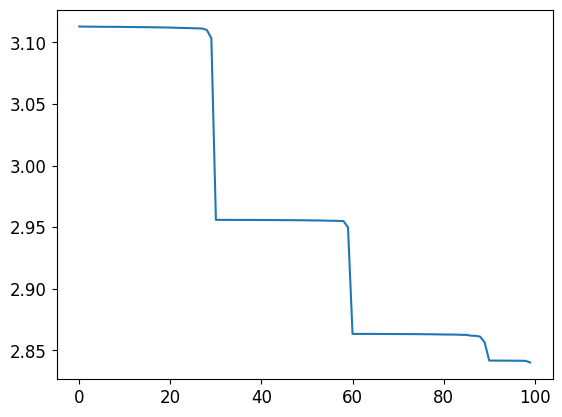

In [20]:
plt.plot(singular_vals_P)

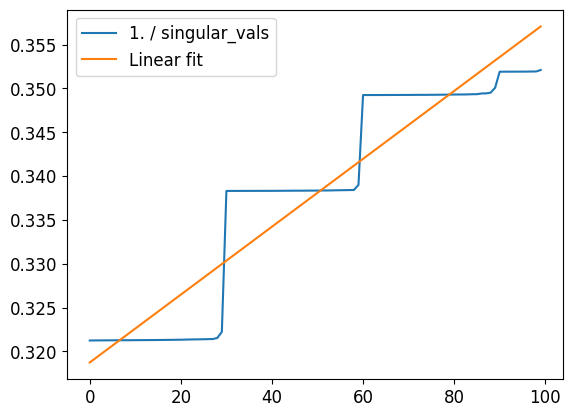

In [21]:
x_vals = np.arange(len(singular_vals_P))
fit = np.polyfit(x_vals, 1. / singular_vals_P, 1)
plt.plot(1. / singular_vals_P)
plt.plot(x_vals, np.poly1d(fit)(x_vals))
plt.legend(['1. / singular_vals', 'Linear fit'])
plt.show()

In [14]:
print(left_singular_vecs_P.shape, right_singular_vecs_P.shape)

(100, 1, 1, 256) (100, 1, 90, 256)


In [25]:
effdim, varrat = p_pT.effrank(singular_vals_P, .95)
print(effdim)
plt.plot(varrat)
plt.axhline(.95)

NameError: name 'p_pT' is not defined

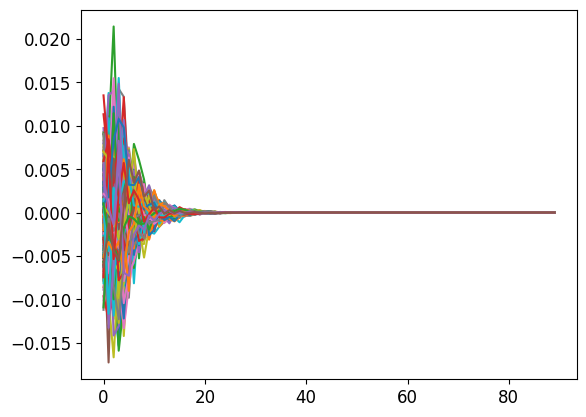

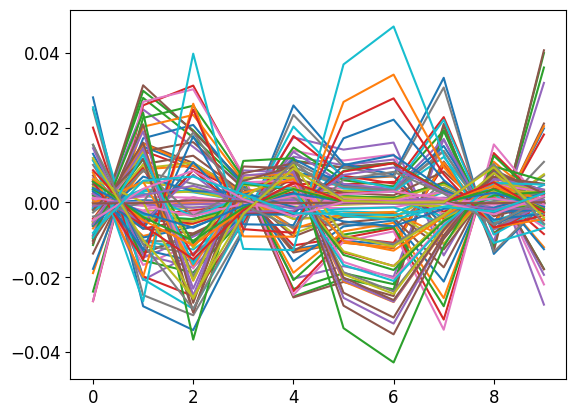

In [22]:
plt.plot(right_singular_vecs_P[0, 0, :, :])
plt.show()

plt.plot(left_singular_vecs_P[:, 0, 0, :10].T)
plt.show()

## Consensus SVD of P

In [24]:
from analysis.op_common import ComposedOperator, TransposedOperator
p_pT = FinalTimeOperator(ComposedOperator(pops['direct'], TransposedOperator(pops['direct'])))
shape_trace_form = (1, *hidden.shape[1:])
p_pT_sp = p_pT.to_scipy(shape_trace_form, float)

singular_vals_P = eigsh(p_pT_sp, k = 1000, return_eigenvectors = False, tol = 1)
singular_vals_P = singular_vals_P[::-1]


# singular_vals_P, singular_vecs_P = eigsh(p_pT_sp, k = 200, return_eigenvectors = True, tol = 1)
# singular_vals_P = singular_vals_P[::-1]
# singular_vecs_P = singular_vecs_P[:, ::-1].T.reshape((-1, *hidden.shape[1:]))

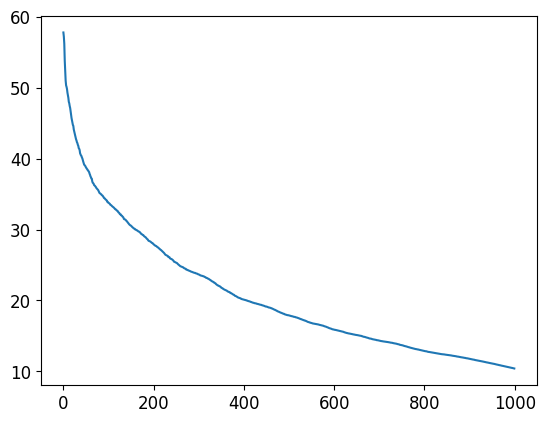

In [25]:
plt.plot(singular_vals_P)

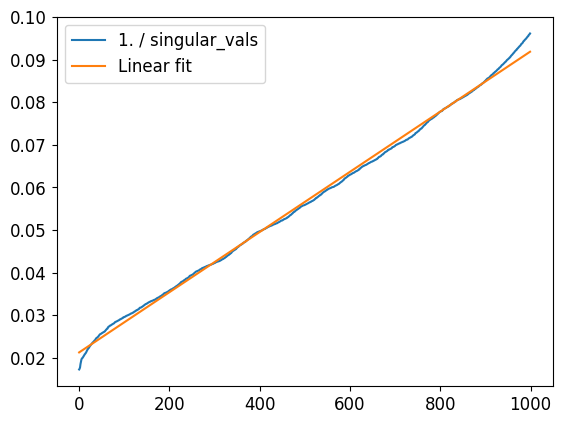

In [46]:
x_vals = np.arange(len(singular_vals_P))
fit = np.polyfit(x_vals, 1. / singular_vals_P, 1)
plt.plot(1. / singular_vals_P)
plt.plot(x_vals, np.poly1d(fit)(x_vals))
plt.legend(['1. / singular_vals', 'Linear fit'])
plt.show()

812.6993085709539


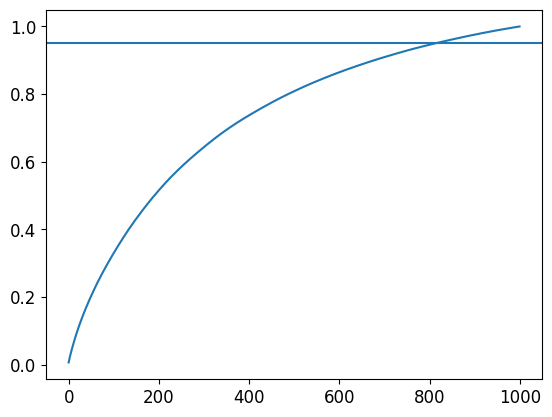

In [39]:
effdim, varrat = p_pT.effrank(singular_vals_P, .95)
print(effdim)
plt.plot(varrat)
plt.axhline(.95)

In [32]:
singular_vecs_P.shape

(30, 90, 256)

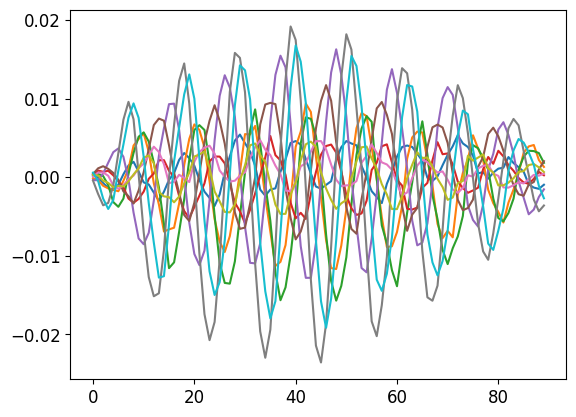

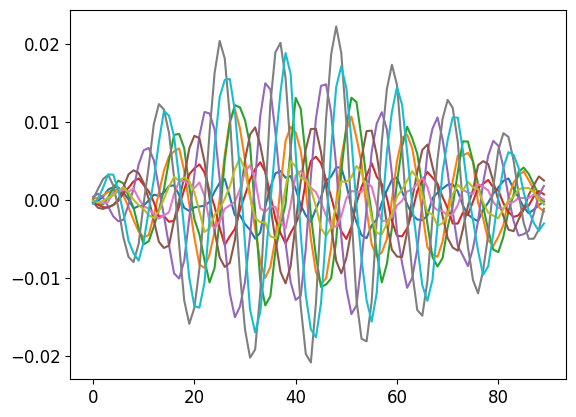

In [30]:
plt.plot(singular_vecs_P[0, :, :10])
plt.show()

plt.plot(singular_vecs_P[1, :, :10])
plt.show()

In [24]:
guess_1 = pop(pop.adjoint_call(hidden * 1e-2))
guess_2 = pop.adjoint_call(pop(hidden * 1e-2))
print(np.abs(guess_1 - guess_2).max() / np.abs(guess_1).max())

0.643355


In [33]:
x = np.random.rand(*hidden.shape).astype(np.double) * 1e-2
y = np.random.rand(*hidden.shape).astype(np.double) * 1e-2
p1 = np.inner(pop(x).flatten(), x.flatten())

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

## Non-consensus SVD of P

In [ ]:
from analysis.op_common import ComposedOperator, TransposedOperator
p_pT = ComposedOperator(pop, TransposedOperator(pop))
p_pT_sp = p_pT.to_scipy(hidden.shape, float)
singular_vals_P, singular_vecs_P = eigsh(p_pT_sp, k = 10, return_eigenvectors = True, tol = 1e-1)
singular_vals_P = singular_vals_P[::-1]
singular_vecs_P = singular_vecs_P[:, ::-1].T.reshape((-1, *hidden.shape))

In [22]:
from scipy.sparse.linalg import lobpcg
ncomp = 10
init_guess = np.random.randn(p_pT_sp.shape[0], ncomp)
eigs, vecs = lobpcg(p_pT_sp, init_guess, tol=1e-4, maxiter=1000)

/tmp/ipykernel_31599/314429813.py:4: UserWarning: Failed at iteration 0 with accuracies [1.52027620e-01 6.96807525e-03 6.32009935e-03 4.76648934e-03
 1.37535618e-04 1.00271245e-05 5.00345146e-05 5.76113810e-04
 4.50440848e-04 4.59535233e-03]
 not reaching the requested tolerance 0.0001.
  eigs, vecs = lobpcg(p_pT_sp, init_guess, tol=1e-4, maxiter=1000)
/tmp/ipykernel_31599/314429813.py:4: UserWarning: Exited at iteration 0 with accuracies 
[1.52027620e-01 6.96807525e-03 6.32009935e-03 4.76648934e-03
 1.37535618e-04 1.00271245e-05 5.00345146e-05 5.76113810e-04
 4.50440848e-04 4.59535233e-03]
not reaching the requested tolerance 0.0001.
Use iteration 0 instead with accuracy 
0.017590178787971915.

  eigs, vecs = lobpcg(p_pT_sp, init_guess, tol=1e-4, maxiter=1000)
/tmp/ipykernel_31599/314429813.py:4: UserWarning: Exited postprocessing with accuracies 
[1.51498065e-01 9.78459269e-04 1.55729227e-16 6.07676088e-17
 4.99997911e-17 4.93027918e-17 4.93525354e-17 4.77878842e-17
 1.28622668e-03 1

In [23]:
print(singular_vals_P)

[0.0302359]


In [25]:
print(eigs[0], singular_vals_P[0])

0.002797313924857359 0.030235896234638987


# Sweep Relevant Plots from Paper

In [90]:
import glob, re
losses = []
scales = []
num_checkpoints = []
sweep_files = glob.glob('mempro_tasks_rnn_100_units_over_scales_4_24_try2/scale_*/')
# sweep_files = glob.glob('mempro_tasks_rnn_256_units_over_scales_4_26_small_sweep/scale_*/')
# sweep_files = glob.glob('mempro_tasks_rnn_256_units_over_scales_4_28_small_sweep_SGD/scale_*/')
sweep_files = glob.glob('mempro_tasks_rnn_256_units_over_scales_5_9_small_sweep_relu/scale_*/')
for idx, fl in enumerate(sweep_files):
    scales.append(float(re.search(r'scale_([0-9]*\.?[0-9]+)', fl).group(1)))

    checkpoints = load_checkpoints(fl)[0]
    num_checkpoints.append(len(checkpoints))
    losses.append(eval_simple_at_iter(-1, checkpoints, inputs, targets, rnn = nn.RNN, hidden_size = 256))

sorted_indices = np.argsort(scales)
losses = np.array(losses)[sorted_indices]
scales = np.array(scales)[sorted_indices]
num_checkpoints = np.array(num_checkpoints)[sorted_indices]
sweep_files = np.array(sweep_files)[sorted_indices]
L0 = 0.333

mask = losses < L0  * 0.1
# mask = losses < L0  * 0.045

losses = losses[mask]
scales = scales[mask]
num_checkpoints = num_checkpoints[mask]
sweep_files = sweep_files[mask]
print(len(sweep_files))

4


In [91]:
from sklearn.decomposition import PCA
def plot_with_periods(data, data_for_pca = None, nplot = 40, fixed_color = None, cmap = 'tab20'):
    # data for pca allows us to fit the PCA to different data than the actual data that we project.
    if data_for_pca is None:
        data_for_pca = data                                                         
    pca = PCA(3).fit(data_for_pca.reshape(-1, data_for_pca.shape[-1]))
    proj = pca.transform(data.reshape(-1, data.shape[-1])).reshape((*data.shape[:-1], 3))

    pallette = plt.get_cmap(cmap)(np.linspace(0, 1, 7))

    for i in range(nplot):
        colors = pallette[[0, 1, 2]]
        if fixed_color is not None:
            colors = [fixed_color] * 4
        for j in range(0, proj.shape[1], 30):
            plt.plot(proj[i, j:j+31, 0], proj[i, j:j+31, 1], proj[i, j:j+31, 2], color = colors[j // 30])

        plt.gca().scatter(*proj[i, -1, :], color = 'black')

def effdim(varexpl, thresh):
    i1 = np.argmax(varexpl > thresh)
    i0 = i1 - 1
    v1 = varexpl[i1]
    v0 = 0. if i1 == 0 else varexpl[i0]
    dim = 1 + (i0 + (thresh - v0) / (v1 - v0)) # Linear interpolation. Also add 1 since dimension is 1 based.
    return dim


def skree_plot(data, data_for_pca = None, ncomp = None, thresh = None, **kwargs):
    if data_for_pca is None:
        data_for_pca = data
    pca = PCA().fit(data_for_pca.reshape(-1, data_for_pca.shape[-1]))
    varrat = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(np.concatenate(([0], varrat[:ncomp]), 0), **kwargs)
    if thresh is not None:
        color = 'black' if 'color' not in kwargs else kwargs['color']
        dim = effdim(varrat, thresh)
        if dim < ncomp:
            plt.axvline(dim, color = color, alpha = .5, linestyle = 'dashed', label = '_nolegend_')


def plot_over_gd(iters, plot_fn, gs, projection = None):
    for idx, (iter, grid_spec) in enumerate(zip(iters, gs)):
        plt.subplot(grid_spec, projection = projection)
        plot_fn(idx, iter)
    plt.tight_layout()


## Compare two scale solutions

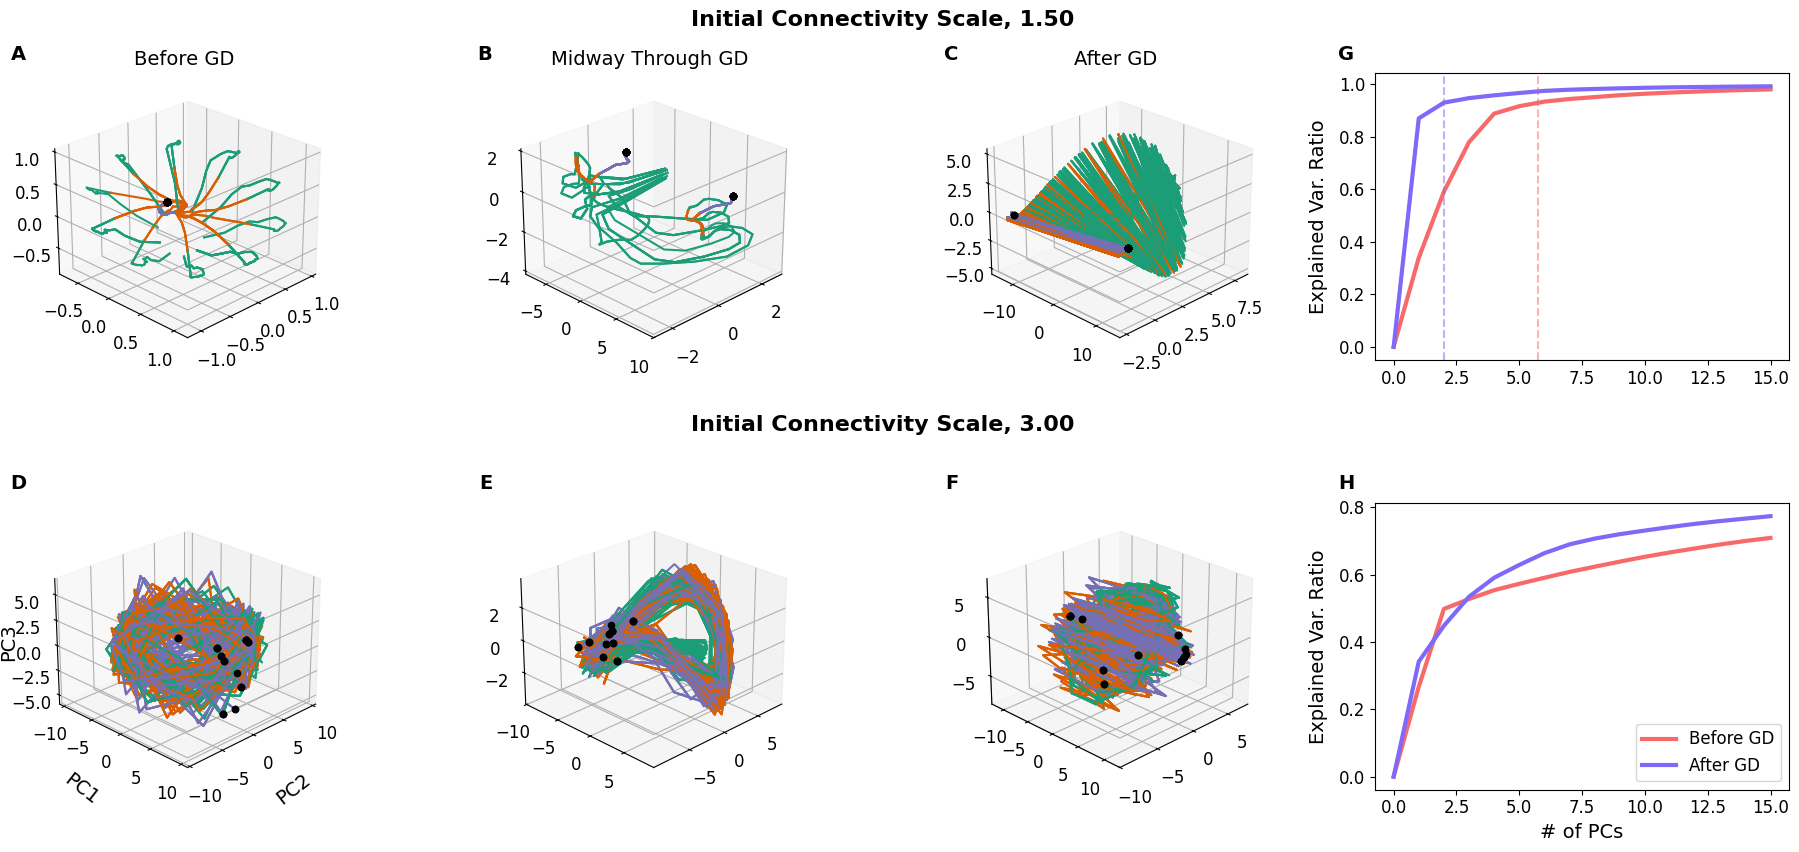

In [94]:
def fn1plot(checkpoints, idx, iter):
    hidden, adjoint = eval_at_iter(iter, checkpoints, inputs, targets, rnn = nn.RNN, hidden_size = 256)[1:3]
    plot_with_periods(hidden, nplot = 30, cmap = 'Dark2')

def fn2plot(checkpoints, ncomp, thresh, idx, iter):
    hidden, adjoint = eval_at_iter(iter, checkpoints, inputs, targets, rnn = nn.RNN, hidden_size = 256)[1:3]
    skree_plot(hidden, ncomp = ncomp, linewidth = 3, color = PALLETTE[idx], thresh = thresh)
# inds_to_plot = [3, 6]     
inds_to_plot = [10, 25]              

inds_to_plot = [1,3]

from functools import partial
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (3.7 * 5, 4.2 * 2))
gs = GridSpec(2, 4, figure=fig)
titles = []
grid_specs = [[gs[0, 0], gs[0, 1], gs[0, 2]], [gs[1, 0], gs[1, 1], gs[1, 2]]]
for plot_idx, idx in enumerate(inds_to_plot):
    checkpoints_at_scale = load_checkpoints(sweep_files[idx])[0] 

    plot_over_gd([0, 10, -1], partial(fn1plot, checkpoints_at_scale), gs = grid_specs[plot_idx], projection = '3d')

    if plot_idx == 0:
        for title, ax in zip(['Before GD', f'Midway Through GD', 'After GD'], fig.axes):
            ax.set_title(title)

# Make the z axis on the left using some random stupid hack i found online
for ax in fig.axes:
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                        tmp_planes[0], tmp_planes[1], 
                        tmp_planes[4], tmp_planes[5])
    view_1 = (25, -135)
    view_2 = (25, -45)
    init_view = view_2
    ax.view_init(*init_view)

fig.axes[3].set_xlabel('PC1', rotation = -38, labelpad = 10)
fig.axes[3].set_ylabel('PC2', rotation  = 38, labelpad = 10)
fig.axes[3].set_zlabel('PC3', rotation = 90, labelpad = -1)

grid_specs = [[gs[0, 3]]*2, [gs[1, 3]]*2]
for plot_idx, idx in enumerate(inds_to_plot):
    checkpoints_at_scale = load_checkpoints(sweep_files[idx])[0] 
    plot_over_gd([0, -1], partial(fn2plot, checkpoints_at_scale, 15, .93), gs = grid_specs[plot_idx])
    if plot_idx == 1:
        plt.legend(['Before GD', 'After GD'])
        plt.xlabel('# of PCs')

    plt.ylabel('Explained Var. Ratio', labelpad = 8)

fig.text(0.5, 1.0, f'Initial Connectivity Scale, {scales[inds_to_plot[0]]:.2f}', ha='center', va='center', fontsize = 2+BIGGER_SIZE, weight='bold')
fig.text(0.5, 0.518, f'Initial Connectivity Scale, {scales[inds_to_plot[1]]:.2f}', ha='center', va='center', fontsize = 2+BIGGER_SIZE, weight='bold')

label_axes_with_alphabet()
plt.tight_layout()

plt.subplots_adjust(hspace=0.5)   # default is ~0.2

plt.savefig("attractors_forming.pdf", bbox_inches="tight", pad_inches=0.1)
plt.savefig('attractors_forming.png')

plt.show()

### Let's go deeper: analyzing the mechanisms behind why in the large init case learning is faster but we get a bottleneck in dim           

In [51]:

def consensus_svd(V, vals_only = False):
    # V is shape [..., B, n, m].
    B, n, m = V.shape[-3:]
    stacked = V.swapaxes(-3,-2).reshape((*V.shape[:-3], n, B*m)) / B
    if vals_only:
        return torch.linalg.svdvals(stacked)
    return torch.linalg.svd(stacked)

def svd_to_lyap(singular_vals, t):
    return np.log(singular_vals / t)
    
def kaplan_yorke_dim(lyaps):
    if not np.any(lyaps > 0.):
        return 0.

    sums = np.cumsum(lyaps)
    N = len(sums)
    if sums[-1] > 0.:
        return N

    cond = np.logical_and(sums[:-1] >= 0., sums[1:] < 0)
    j = N - 1 - np.argmax(cond[::-1]) # We pick the largest index. 
    return j + 1 + sums[j] / np.abs(lyaps[j+1])

def kp_dim_at_checkpoint(ch, rnn = nn.GRU, hidden_size = 100, return_lyap = False):
    pop = evaluate_prop_op_with_scale(inputs, 1.0, ch, rnn = rnn, hidden_size = hidden_size)
    singular_vals = consensus_svd(pop.Us[:, -1], vals_only = True).detach().numpy()
    lyap = np.log(singular_vals) / pop.Us.shape[1]
    return kaplan_yorke_dim(lyap) if not return_lyap else kaplan_yorke_dim(lyap), lyap

def k_operator_dim_at_checkpoint(ch, nfuns = 15, rnn = nn.GRU, hidden_size = 100):
    op = evaluate_kernel_op_with_scale(inputs, 1.0, ch, rnn = rnn, hidden_size = hidden_size)
    shape = (inputs.shape[0], inputs.shape[1], 1)
    op_sp = op.to_scipy(shape = shape, dtype = float)
    from scipy.sparse.linalg import eigsh
    singular_vals = eigsh(op_sp, k = nfuns, return_eigenvectors = False)[::-1]
    print(singular_vals)
    # pc_funs, singular_vals = op.svd(ncomps = nfuns, shape = shape, dtype = float)
    # pc_funs = pc_funs[..., 0] # squeeze
    effrank, varrat = op.effrank(singular_vals, .95)

    plt.plot(singular_vals)
    plt.show()

    return effrank, varrat


def k_operator_eigfuns_at_checkpoint(ch, nfuns = 15, rnn = nn.GRU, hidden_size = 100):
    op = evaluate_kernel_op_with_scale(inputs, 1.0, ch, rnn = rnn, hidden_size = hidden_size)
    shape = (inputs.shape[0], inputs.shape[1], 1)
    op_sp = op.to_scipy(shape = shape, dtype = float)
    from scipy.sparse.linalg import eigsh
    singular_vals, singular_funs = eigsh(op_sp, k = nfuns, return_eigenvectors = True)
    return singular_vals[::-1], np.moveaxis(singular_funs[:, ::-1].reshape((inputs.shape[0], inputs.shape[1], -1)), -1,0)
    

  0%|          | 0/10 [00:00<?, ?it/s]

[54992.71829107  6186.52198755  5832.28754037  3389.53358102
  3177.74395863  2748.14288696  2566.97231151  2426.40106746
  2188.13814368  2071.39917945]


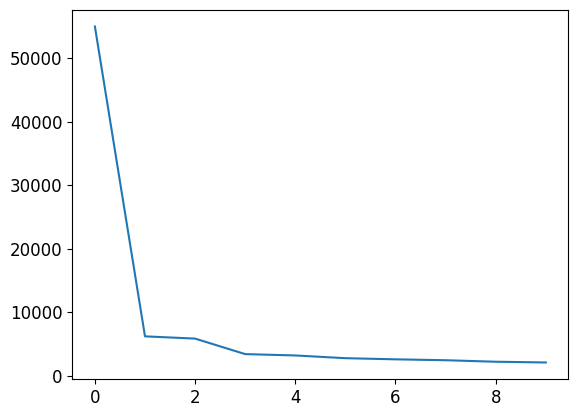

 10%|█         | 1/10 [00:13<02:00, 13.34s/it]

[109481.27697421  14554.97779421   5842.19127579   4201.89339171
   2637.61728312   2361.82631693   1722.40631961   1433.28548597
   1274.24717693    999.49246702]


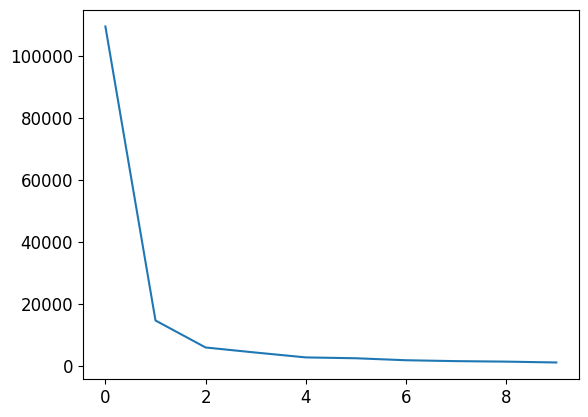

 20%|██        | 2/10 [00:24<01:34, 11.78s/it]

[108490.88716366  14895.49958691   6112.34673587   4185.62424294
   3354.13199642   2638.50534137   1643.91932313   1384.31035672
   1116.67008826    944.01522542]


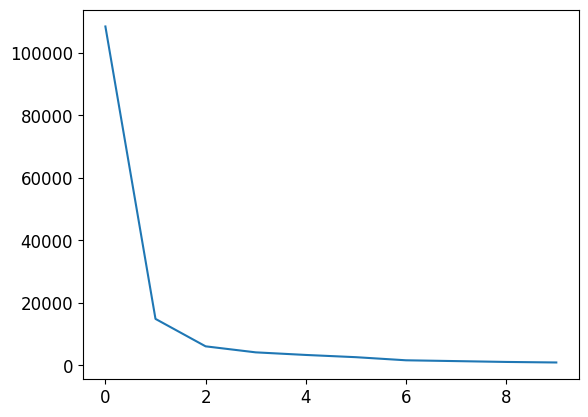

 30%|███       | 3/10 [00:34<01:17, 11.08s/it]

[108367.65464509  14854.27594994   6222.01883672   4304.93478456
   3492.76580873   2723.88285509   1620.52666928   1394.94292123
   1068.65121741    913.56726229]


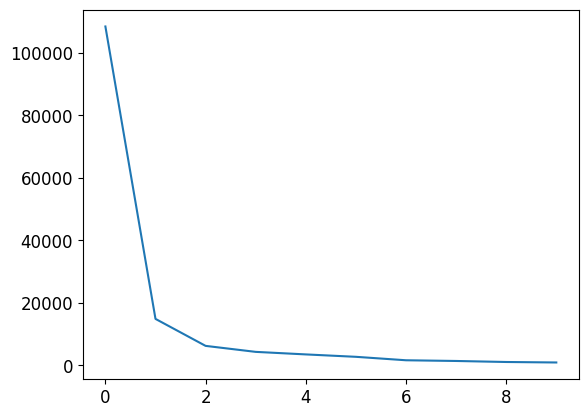

 40%|████      | 4/10 [00:44<01:03, 10.59s/it]

[107979.06746866  15074.68044117   6377.72080336   4340.42457674
   3588.33880307   2775.59983891   1621.47934583   1396.56939285
   1053.91519898    903.74228412]


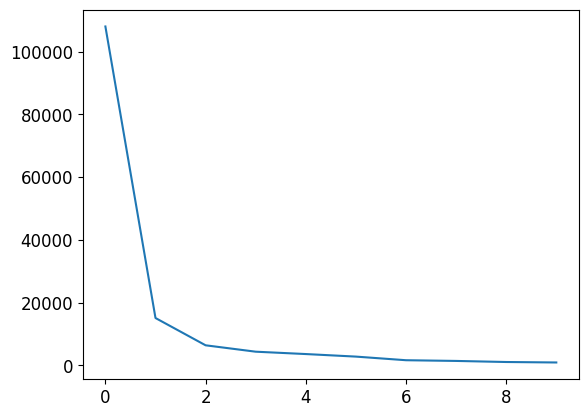

 50%|█████     | 5/10 [00:54<00:52, 10.46s/it]

[107729.31595623  15348.53745867   6473.79994887   4361.73774287
   3626.35958639   2811.30368098   1619.77231395   1390.76473186
   1039.84619228    884.86094023]


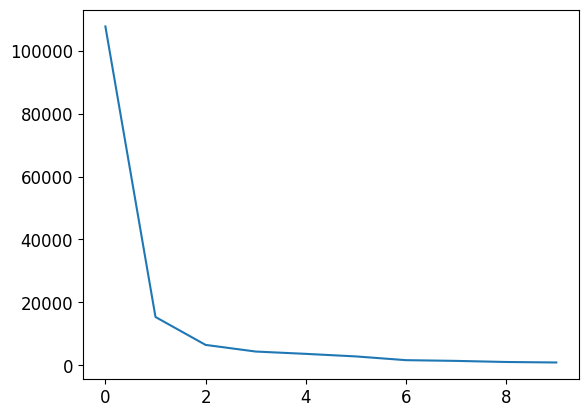

 60%|██████    | 6/10 [01:04<00:40, 10.22s/it]

[107455.64554683  15653.1049778    6563.36846778   4381.3113957
   3650.04679118   2844.89879391   1618.15103947   1387.46818958
   1030.31731656    881.54023195]


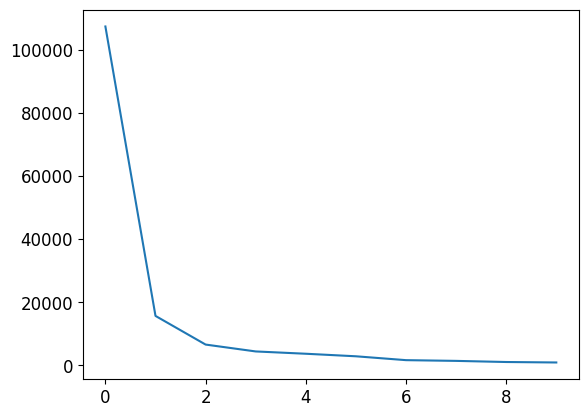

 70%|███████   | 7/10 [01:13<00:30, 10.03s/it]

[107186.83570935  15911.58787599   6648.02700245   4401.55208202
   3691.49552528   2876.92345324   1616.32525734   1386.74981052
   1025.26552281    886.65523392]


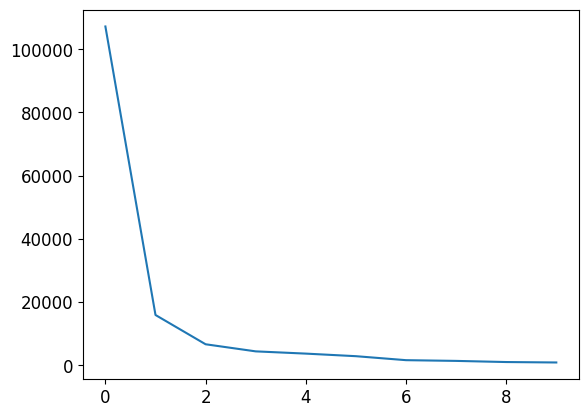

 80%|████████  | 8/10 [01:23<00:19,  9.97s/it]

[107006.09205046  16118.05148557   6710.75463803   4407.52423332
   3715.17780091   2903.36881505   1615.57933198   1387.45712076
   1023.70906778    895.89458756]


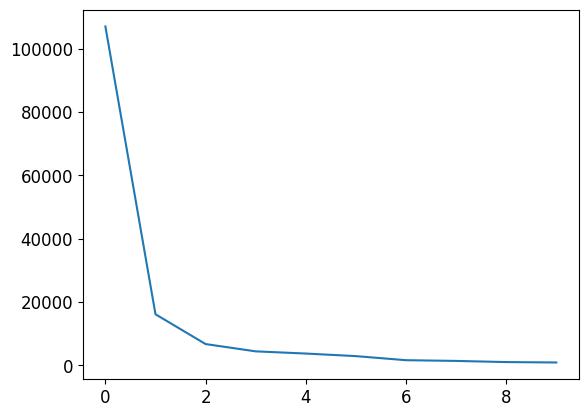

 90%|█████████ | 9/10 [01:33<00:10, 10.03s/it]

[106797.24366289  16301.95786345   6784.89529542   4413.16724869
   3753.11199326   2928.7574294    1615.22094413   1389.89772606
   1024.365283      905.10368546]


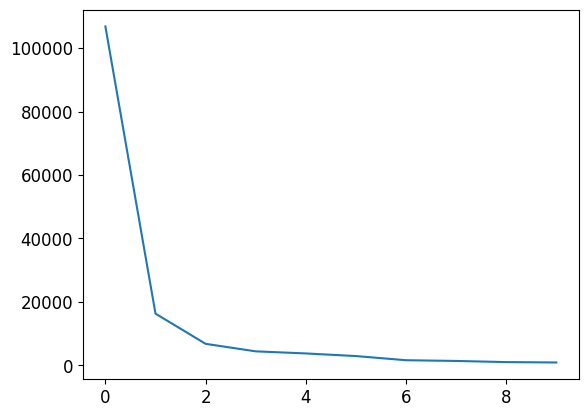

100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 2) + inhomogeneous part.

In [86]:
k_op_dim_big_init = []
kp_dim_big_init = []
        checkpoints_big_init = load_checkpoints(sweep_files[0])[0] 
for ch in tqdm(checkpoints_big_init[::100]):
    kp_dim_big_init.append(kp_dim_at_checkpoint(ch, rnn=nn.RNN, hidden_size = 256))
    k_op_dim_big_init.append(k_operator_dim_at_checkpoint(ch, nfuns = 10, rnn=nn.RNN, hidden_size = 256))
kp_dim_big_init = np.array(kp_dim_big_init)
k_op_dim_big_init = np.array(k_op_dim_big_init)

In [77]:
k_op_dim_small_init = []            
kp_dim_small_init = []
checkpoints_small_init = load_checkpoints(sweep_files[3])[0] 
for ch in tqdm(checkpoints_small_init[::10]):
    kp_dim_small_init.append(kp_dim_at_checkpoint(ch, rnn=nn.RNN, hidden_size = 256))
    k_op_dim_small_init.append(k_operator_dim_at_checkpoint(ch, nfuns = 10, rnn=nn.RNN, hidden_size = 256))
kp_dim_small_init = np.array(kp_dim_small_init)
k_op_dim_small_init = np.array(k_op_dim_small_init)

IndexError: index 3 is out of bounds for axis 0 with size 1

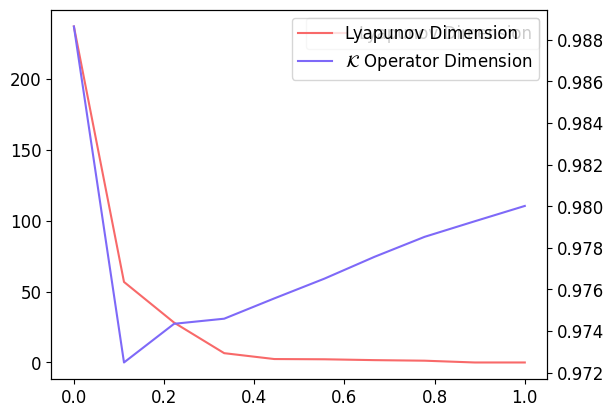

In [93]:
ln1 = plt.plot(np.linspace(0, 1., len(kp_dim_big_init)), [K[0] for K in kp_dim_big_init], color = PALLETTE[0])
plt.legend(['Lyapunov Dimension'])  
ax2 = plt.gca().twinx()
ln2 = plt.plot(np.linspace(0, 1., len(kp_dim_big_init)), [K[0] for K in k_op_dim_big_init], color = PALLETTE[1])
plt.xlabel('GD Progress %')
ax2.legend(ln1+ln2, ['Lyapunov Dimension', '$\\mathcal{K}$ Operator Dimension'], loc=0)
# plt.savefig('Trend_dims_SGD.pdf')

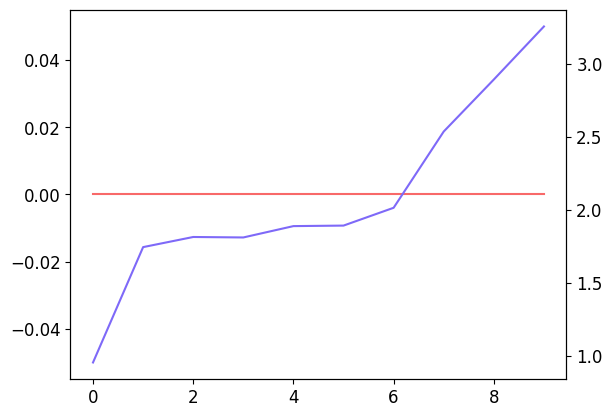

In [30]:
plt.plot([K[0] for K in kp_dim_small_init], color = PALLETTE[0])            
plt.gca().twinx()
plt.plot([K[0] for K in k_op_dim_small_init], color = PALLETTE[1])

### Hypothesis: K is low-D at the start. It pulls only a few dimenisons out and all the other ones stop being dominant. 

In [71]:
svs0, sfuns0 = k_operator_eigfuns_at_checkpoint(checkpoints_big_init[0], nfuns = 15, rnn = nn.RNN, hidden_size = 256)
weighted_sfuns0 = svs0[:, None, None] * sfuns0
svs1, sfuns1 = k_operator_eigfuns_at_checkpoint(checkpoints_big_init[1], nfuns = 15, rnn = nn.RNN, hidden_size = 256)
weighted_sfuns1 = svs1[:, None, None] * sfuns1


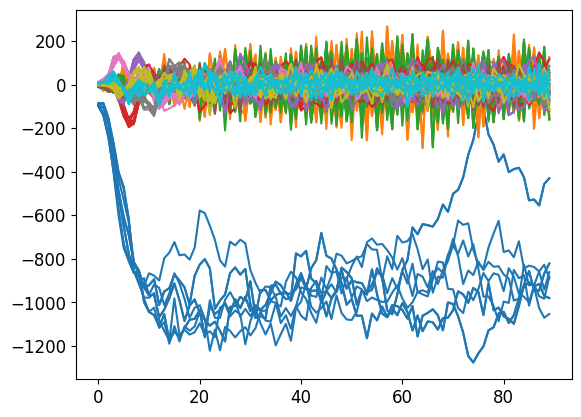

In [73]:
m = 10 
cmap = plt.get_cmap('tab20')
for idx, wsfun in enumerate(weighted_sfuns0             [:m]):
    plt.plot(wsfun[:10, :].T, color = cmap(idx  / m))
plt.show()

In [855]:
svs, sfuns = k_operator_eigfuns_at_checkpoint(checkpoints_big_init[1], nfuns = 15, rnn = nn.RNN, hidden_size = 256)
weighted_sfuns = svs[:, None, None] * sfuns             
sfuns.shape

(15, 40, 90)

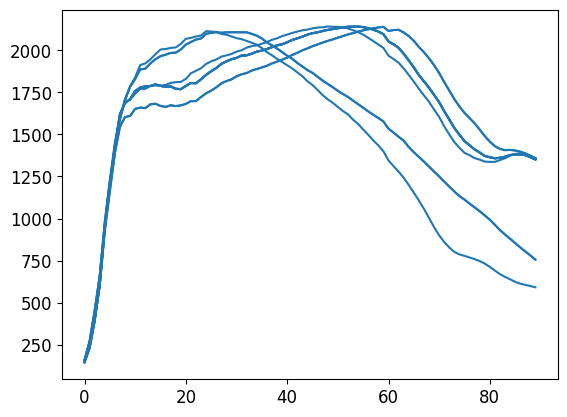

In [858]:
m = 1   
cmap = plt.get_cmap('tab20')
for idx, wsfun in enumerate(weighted_sfuns[:m]):
    plt.plot(wsfun[:10, :].T, color = cmap(idx  / m))
plt.show()

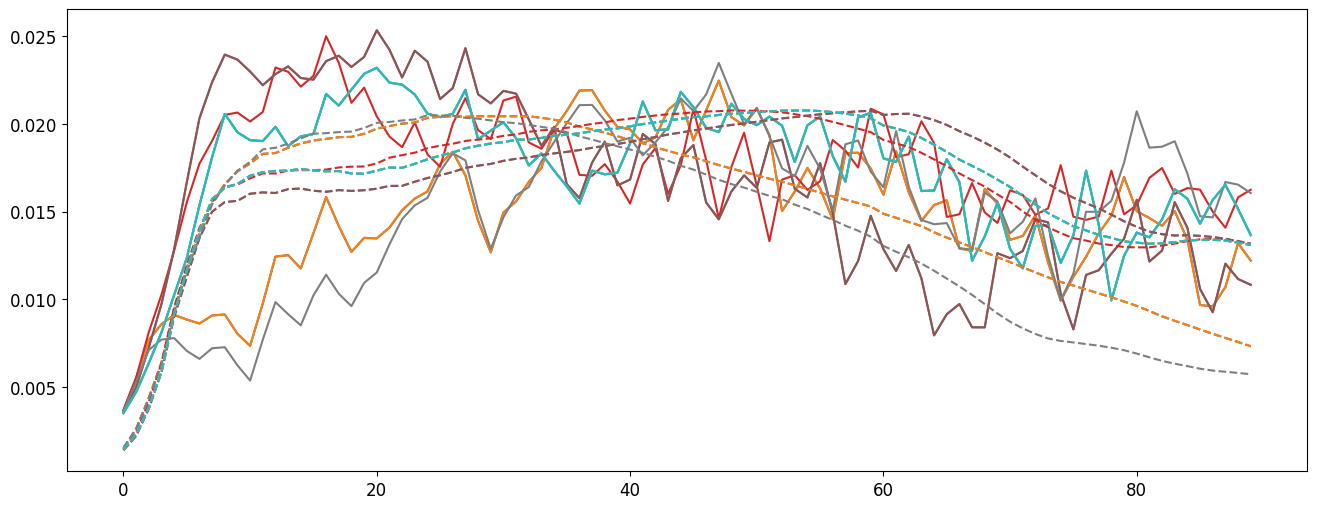

In [868]:
plt.figure(figsize = (16, 6))
# plt.subplot(1,2,1)
plt.plot(sfuns0[0, :10, :].T)
# plt.subplot(1,2,2)
plt.plot(sfuns1[0, :10, :].T, linestyle = 'dashed')                                                     
plt.show()

In [904]:
print(np.linalg.norm(W1) / np.linalg.norm(W0) * np.mean(sig_prime1) / np.mean(sig_prime0))

0.94247913


In [75]:
_, lyap0 = kp_dim_at_checkpoint(checkpoints_big_init[0], rnn = nn.RNN, hidden_size = 256, return_lyap = True)
_, lyap1 = kp_dim_at_checkpoint(checkpoints_big_init[1], rnn = nn.RNN, hidden_size = 256, return_lyap = True)
_, lyapf = kp_dim_at_checkpoint(checkpoints_big_init[-1], rnn = nn.RNN, hidden_size = 256, return_lyap = True)

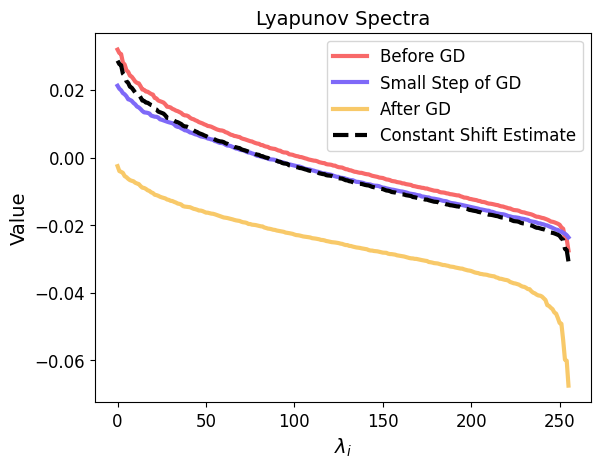

In [76]:
plt.plot(lyap0, linewidth = 3, color = PALLETTE[0])
plt.plot(lyap1, linewidth = 3, color = PALLETTE[1])
plt.plot(lyapf, linewidth = 3, color = PALLETTE[2])

mean_diff = np.mean(lyap1 - lyap0)

plt.plot(lyap0 + mean_diff, linewidth = 3, linestyle = 'dashed', color = 'black')

plt.legend(['Before GD', 'Small Step of GD', 'After GD', 'Constant Shift Estimate'])
plt.title('Lyapunov Spectra')
plt.xlabel('$\\lambda_i$')
plt.ylabel('Value')

plt.savefig('lyap_supp.pdf')
plt.savefig('lyap_supp.png')
plt.show()

In [899]:
print(mean_diff, np.exp(mean_diff), )

-0.01265185 0.98742783


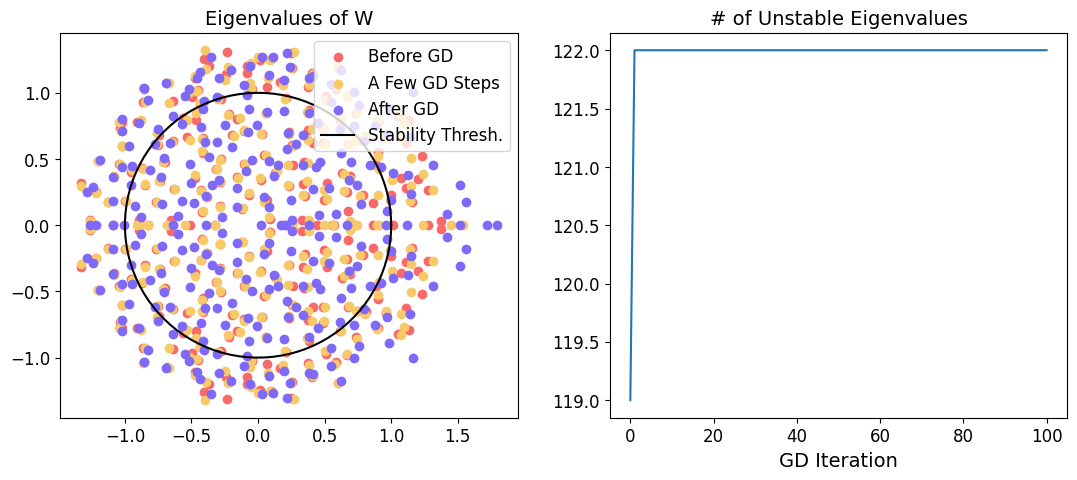

In [900]:
W0 = import_checkpoint(checkpoints_big_init[0])['rnn.weight_hh_l0'].detach().cpu().numpy()
W1 = import_checkpoint(checkpoints_big_init[1])['rnn.weight_hh_l0'].detach().cpu().numpy()
Wf = import_checkpoint(checkpoints_big_init[-1])['rnn.weight_hh_l0'].detach().cpu().numpy()

eigvals0 = np.linalg.eigvals(W0)
eigvals1 = np.linalg.eigvals(W1)
eigvalsf = np.linalg.eigvals(Wf)

plt.figure(figsize = (13, 5))

plt.subplot(1,2,1)
plt.scatter(np.real(eigvals0), np.imag(eigvals0), color = PALLETTE[0])
plt.scatter(np.real(eigvals1), np.imag(eigvals1), color = PALLETTE[2])
plt.scatter(np.real(eigvalsf), np.imag(eigvalsf), color = PALLETTE[1])
ang = np.linspace(0., 2*np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang), color = 'black')
plt.title('Eigenvalues of W')
plt.legend(['Before GD', 'A Few GD Steps', 'After GD', 'Stability Thresh.'])

plt.subplot(1,2,2)
plt.plot([0, 1, len(checkpoints_big_init)], [sum(np.abs(ev) > 1) for ev in [eigvals0, eigvals1, eigvalsf]])
plt.title('# of Unstable Eigenvalues')
plt.xlabel('GD Iteration')

plt.show()

In [911]:
pop0 = evaluate_prop_op_with_scale(inputs, 1.0, checkpoints_big_init[0], rnn = nn.RNN, hidden_size = 256)
pop1 = evaluate_prop_op_with_scale(inputs, 1.0, checkpoints_big_init[1], rnn = nn.RNN, hidden_size = 256)

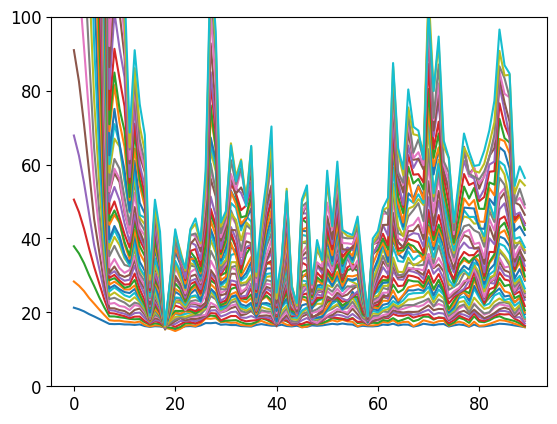

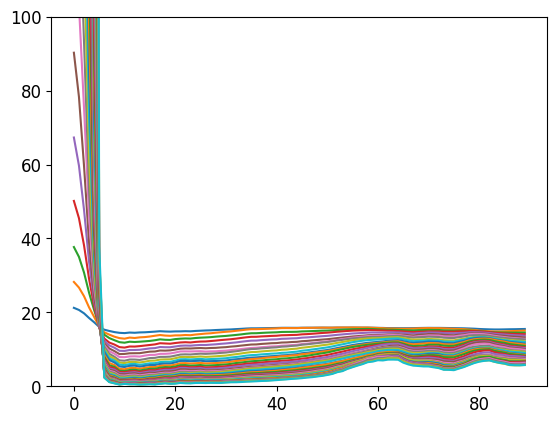

In [915]:
plt.plot(np.linalg.norm(pop0.Us, axis = (-2, -1)).T)
plt.ylim(0, 100)
plt.show()

plt.plot(np.linalg.norm(pop1.Us, axis = (-2, -1)).T)
plt.ylim(0, 100)
plt.show()


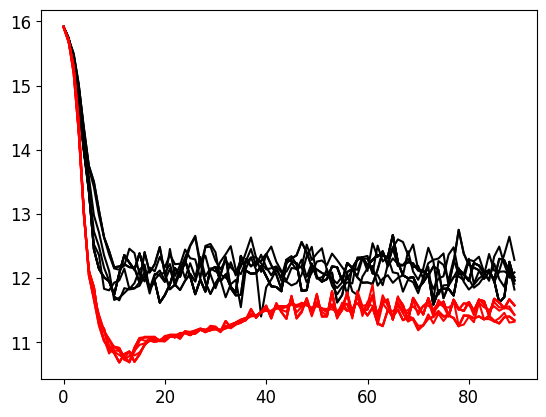

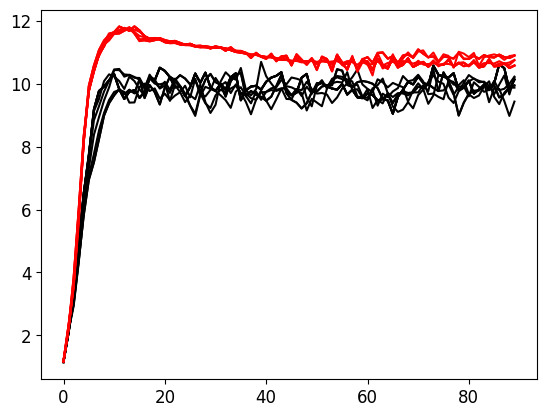

In [22]:
hidden0, adjoint0 = eval_at_iter(0, checkpoints_big_init, inputs, targets, rnn = nn.RNN, hidden_size = 256)[1:3]
hidden1, adjoint1 = eval_at_iter(1, checkpoints_big_init, inputs, targets, rnn = nn.RNN, hidden_size = 256)[1:3]

sig_prime0 = 1. / np.cosh(hidden0)**2
sig_prime1 = 1. / np.cosh(hidden1)**2

plt.plot(np.linalg.norm(sig_prime0, axis = -1)[:10].T, color = 'black')
plt.plot(np.linalg.norm(sig_prime1, axis = -1)[:10].T, color = 'red')
plt.show()

plt.plot(np.linalg.norm(hidden0, axis = -1)[:10].T, color = 'black')
plt.plot(np.linalg.norm(hidden1, axis = -1)[:10].T, color = 'red')
plt.show()

In [20]:
checkpoints_small_init = load_checkpoints(sweep_files[3])[0] 
pop0 = evaluate_prop_op_with_scale(inputs, 1.0, checkpoints_small_init[0], rnn = nn.RNN, hidden_size = 256)
pop1 = evaluate_prop_op_with_scale(inputs, 1.0, checkpoints_small_init[1], rnn = nn.RNN, hidden_size = 256)

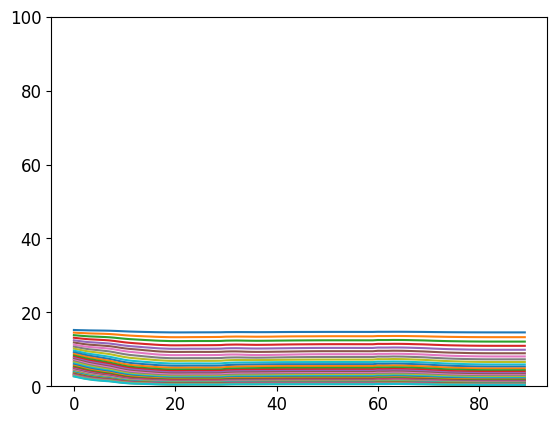

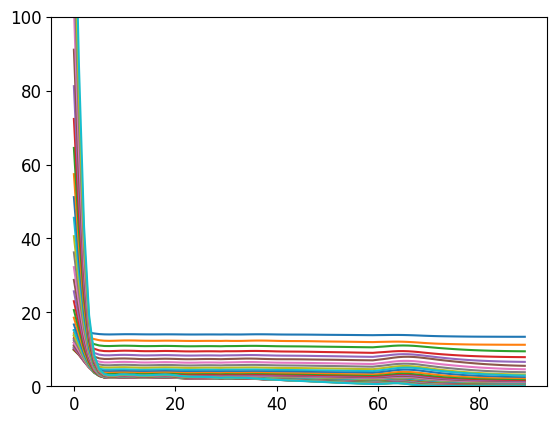

In [21]:
plt.plot(np.linalg.norm(pop0.Us, axis = (-2, -1)).T)
plt.ylim(0, 100)
plt.show()

plt.plot(np.linalg.norm(pop1.Us, axis = (-2, -1)).T)
plt.ylim(0, 100)
plt.show()


In [ ]:
svs, sfuns = k_operator_eigfuns_at_checkpoint(checkpoints_big_init[1], nfuns = 15, rnn = nn.RNN, hidden_size = 256)
weighted_sfuns = svs[:, None, None] * sfuns
sfuns.shape

(15, 40, 90)

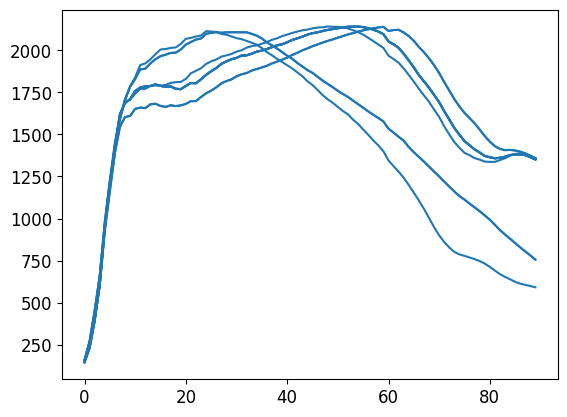

In [ ]:
m = 1
cmap = plt.get_cmap('tab20')
for idx, wsfun in enumerate(weighted_sfuns[:m]):
    plt.plot(wsfun[:10, :].T, color = cmap(idx  / m))
plt.show()

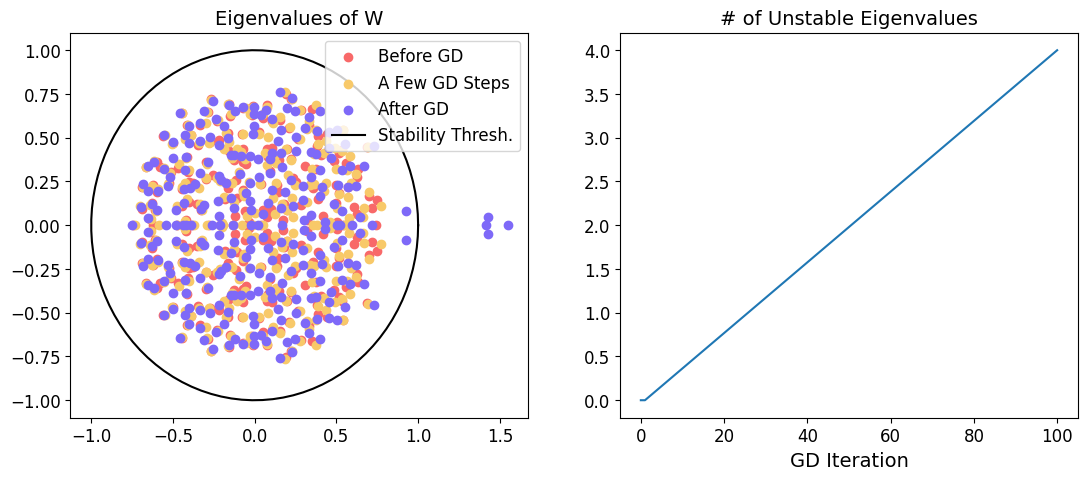

In [846]:
checkpoints_small_init = load_checkpoints(sweep_files[3])[0] 
W0 = import_checkpoint(checkpoints_small_init[0])['rnn.weight_hh_l0'].detach().cpu().numpy()
W1 = import_checkpoint(checkpoints_small_init[1])['rnn.weight_hh_l0'].detach().cpu().numpy()
Wf = import_checkpoint(checkpoints_small_init[-1])['rnn.weight_hh_l0'].detach().cpu().numpy()

eigvals0 = np.linalg.eigvals(W0)
eigvals1 = np.linalg.eigvals(W1)
eigvalsf = np.linalg.eigvals(Wf)

plt.figure(figsize = (13, 5))

plt.subplot(1,2,1)
plt.scatter(np.real(eigvals0), np.imag(eigvals0), color = PALLETTE[0])
plt.scatter(np.real(eigvals1), np.imag(eigvals1), color = PALLETTE[2])
plt.scatter(np.real(eigvalsf), np.imag(eigvalsf), color = PALLETTE[1])
ang = np.linspace(0., 2*np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang), color = 'black')
plt.title('Eigenvalues of W')
plt.legend(['Before GD', 'A Few GD Steps', 'After GD', 'Stability Thresh.'])

plt.subplot(1,2,2)
plt.plot([0, 1, len(checkpoints_small_init)], [sum(np.abs(ev) > 1) for ev in [eigvals0, eigvals1, eigvalsf]])
plt.title('# of Unstable Eigenvalues')
plt.xlabel('GD Iteration')

plt.show()

In [789]:

kp_dim = []
inds_lyap = np.concatenate((np.array([0, 100, 200]), np.linspace(300, len(sweep_files)-1, 30)), 0).astype(int)
inds_lyap = np.concatenate((np.linspace(0, 200, 30), np.linspace(300, len(sweep_files)-1, 100)), 0).astype(int)
for file in tqdm(sweep_files[inds_lyap]):
    checkpoints = load_checkpoints(f'{file}/')[0]
    kp_dim.append([])
    for ch in [checkpoints[0], checkpoints[-1]]:
        kp_dim[-1].append(kp_dim_at_checkpoint(ch, rnn=nn.RNN, hidden_size = 256))
kp_dim = np.array(kp_dim)

IndexError: index 13 is out of bounds for axis 0 with size 9

In [126]:
# def eval_rank(ch, scale = 1, nfuns = 20):
#     op = evaluate_kernel_op_with_scale(inputs, scale, checkpoint = ch)
#     shape = Model()(inputs)[1].shape
#     shape = (*shape[:-1], 1)
#     pc_funs, singular_vals = op.svd(ncomps = nfuns, shape = shape, dtype = float)
#     pc_funs = pc_funs[..., 0] # squeeze
#     effrank, varrat = op.effrank(singular_vals, .95)
#     return effrank, varrat, op

def k_operator_dim_at_checkpoint(ch, nfuns = 15, rnn = nn.GRU, hidden_size = 100):
    op = evaluate_kernel_op_with_scale(inputs, 1.0, ch, rnn = rnn, hidden_size = hidden_size)
    shape = (inputs.shape[0], inputs.shape[1], 1)
    op_sp = op.to_scipy(shape = shape, dtype = float)
    from scipy.sparse.linalg import eigsh
    singular_vals = eigsh(op_sp, k = nfuns, return_eigenvectors = False)
    # pc_funs, singular_vals = op.svd(ncomps = nfuns, shape = shape, dtype = float)
    # pc_funs = pc_funs[..., 0] # squeeze
    effrank, varrat = op.effrank(singular_vals, .95)
    return effrank, varrat


k_op_dim = []
for file in tqdm(sweep_files[inds_lyap]):
    checkpoints = load_checkpoints(f'{file}/')[0]
    k_op_dim.append([])
    for ch in [checkpoints[0], checkpoints[-1]]:
        k_op_dim[-1].append(k_operator_dim_at_checkpoint(ch, nfuns = 10, rnn=nn.RNN, hidden_size = 256)[0])
k_op_dim = np.array(k_op_dim)

100%|██████████| 130/130 [19:42<00:00,  9.10s/it]


In [132]:
# np.save('k_op_dim_rnn.npy', k_op_dim)
# np.save('kp_dim_rnn.npy', kp_dim)

In [316]:
kp_dim, k_op_dim = np.load('kp_dim_rnn.npy'), np.load('k_op_dim_rnn.npy')

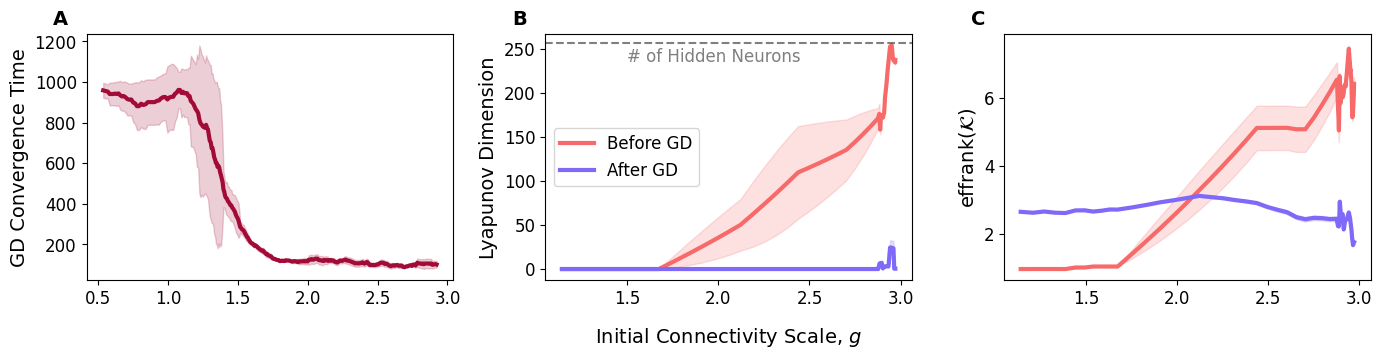

In [326]:
plt.figure(figsize = (14, 3.8))

# colors = ["#A30B37", "C0", "C1"]

plt.subplot(1,3,1)
plot_smooth(scales, num_checkpoints * 20., 20, var_scale = .01, color = "#A30B37", linewidth = 3., fill_kwargs = {'color': "#A30B37", 'alpha': 0.2})
plt.ylabel('GD Convergence Time')

plt.subplot(1,3,2)
plot_smooth(scales[inds_lyap], kp_dim[:len(inds_lyap), 0], 20, var_scale = .005, color = PALLETTE[0], linewidth = 3., fill_kwargs = {'color': PALLETTE[0], 'alpha': 0.2, 'label': '_nolegend_'})
plot_smooth(scales[inds_lyap], kp_dim[:len(inds_lyap), 1], 20, var_scale = .005, color = PALLETTE[1], linewidth = 3., fill_kwargs = {'color': PALLETTE[1], 'alpha': 0.2, 'label': '_nolegend_'})
plt.axhline(256, color = 'black', alpha = .5, linestyle = 'dashed')
plt.text(1.5, 235, '# of Hidden Neurons', alpha = .5)
plt.ylabel('Lyapunov Dimension')
plt.xlabel('Initial Connectivity Scale, $g$', labelpad=13)
plt.legend(['Before GD', 'After GD'])

plt.subplot(1,3,3)
plot_smooth(scales[inds_lyap], k_op_dim[:len(inds_lyap), 0], 20, var_scale = .05, color = PALLETTE[0], linewidth = 3., fill_kwargs = {'color': PALLETTE[0], 'alpha': 0.2, 'label': '_nolegend_'})
plot_smooth(scales[inds_lyap], k_op_dim[:len(inds_lyap), 1], 20, var_scale = .05, color = PALLETTE[1], linewidth = 3., fill_kwargs = {'color': PALLETTE[1], 'alpha': 0.2, 'label': '_nolegend_'})
plt.ylabel('effrank($\\mathcal{K}$)')

label_axes_with_alphabet()

plt.tight_layout()
plt.savefig('dimensions_over_scales.pdf')
plt.savefig('dimensions_over_scales.png')

plt.show()

In [78]:
plt.plot([[dim]])

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0],
 [0.0],
 [0.0],
 [166.94807589799166],
 [181.44494479894638],
 [256]]

In [114]:
singular_vals = consensus_svd(pop.Us.swapaxes(0,1), vals_only = True)

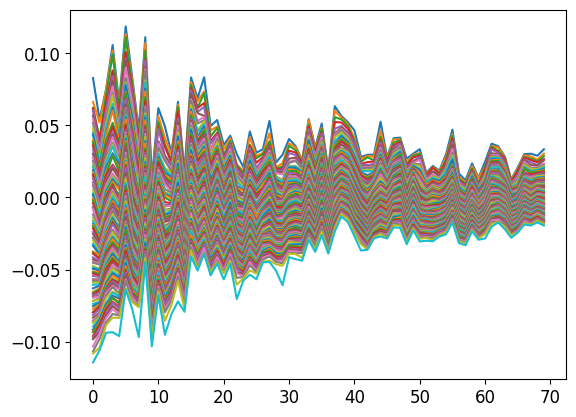

tensor(52)


In [122]:
lyaps = np.log(singular_vals) / (1+np.arange(pop.Us.shape[1])[:, None])
plt.plot(lyaps[20:, :])
# plt.ylim(-.25,0)
plt.show()

print(torch.sum(lyaps[-1] > 0))

In [96]:
# checkpoints = load_checkpoints('mempro_tasks_rnn_100_units/repeat_0/')[0]
checkpoints = load_checkpoints('mempro_tasks_rnn_100_units_over_scales/scale_1.0080808080808081/')[0]

singular_vals_over_GD = []
for ch in checkpoints[::10]:
    pop = evaluate_prop_op_with_scale(inputs, 1., ch, rnn = nn.RNN)
    singular_vals_over_GD.append(consensus_svd(pop.Us[:, -1], vals_only = True))
singular_vals_over_GD = np.array(singular_vals_over_GD)

(40, 90, 100)
(40, 90, 100)
(40, 90, 100)
(40, 90, 100)
(40, 90, 100)


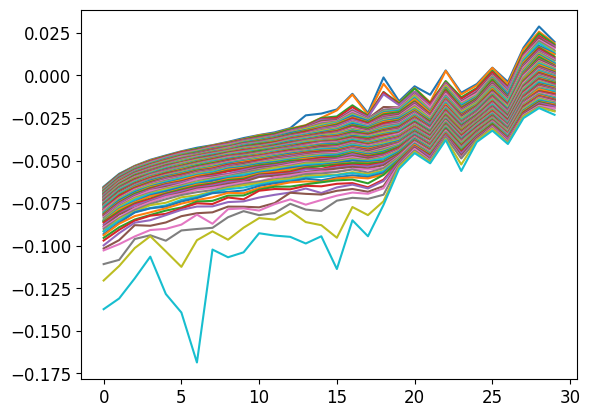

In [155]:
lyap_over_GD = np.log(singular_vals_over_GD) / pop.Us.shape[1]
plt.plot(lyap_over_GD[:, :])
plt.show()

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


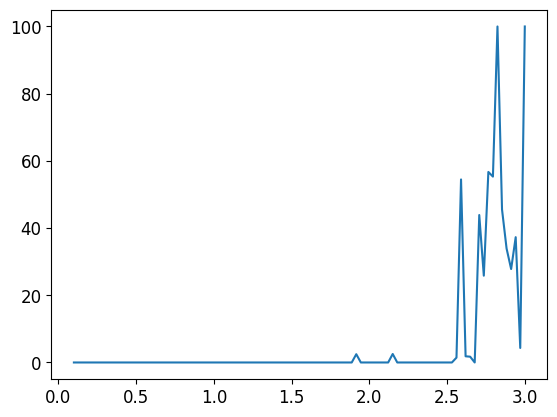

In [161]:
def kaplan_yorke_dim(lyaps):
    if not np.any(lyaps > 0.):
        return 0.

    sums = np.cumsum(lyaps)
    N = len(sums)
    if sums[-1] > 0.:
        return N

    cond = np.logical_and(sums[:-1] >= 0., sums[1:] < 0)
    j = N - 1 - np.argmax(cond[::-1]) # We pick the largest index. 
    return j + 1 + sums[j] / np.abs(lyaps[j+1])

# checkpoints = load_checkpoints('mempro_tasks_rnn_100_units/repeat_0/')[0]
scales = np.linspace(0.1, 3.0, 100)
singular_vals_over_scales = []
for scale in tqdm(scales):
    pop = evaluate_prop_op_with_scale(inputs, scale, '', rnn = nn.RNN)
    singular_vals_over_scales.append(consensus_svd(pop.Us[:, -1], vals_only = True))
singular_vals_over_scales = np.array(singular_vals_over_scales)
lyap_over_scales = np.log(singular_vals_over_scales) / pop.Us.shape[1]

dims = np.apply_along_axis(kaplan_yorke_dim, 1, lyap_over_scales)

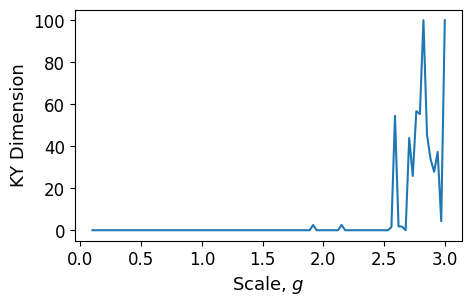

In [163]:
plt.figure(figsize = (5, 3))
plt.plot(scales, dims)
plt.xlabel('Scale, $g$')
plt.ylabel('KY Dimension')
plt.show()

In [9]:
ranks = []
scales = np.linspace(1.4, 3.0, 100)
for scale in tqdm(scales):
    ranks.append(eval_rank('', scale)[0])
plt.plot(scales, ranks)

  1%|          | 1/100 [00:04<06:54,  4.19s/it]capi_return is NULL
Call-back cb_matvec_in_idd__user__routines failed.
  1%|          | 1/100 [00:05<09:47,  5.93s/it]


KeyboardInterrupt: 

In [258]:
np.save('ranks_rnn.npy', ranks)
np.save('varrats_rnn.npy', varrats)

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


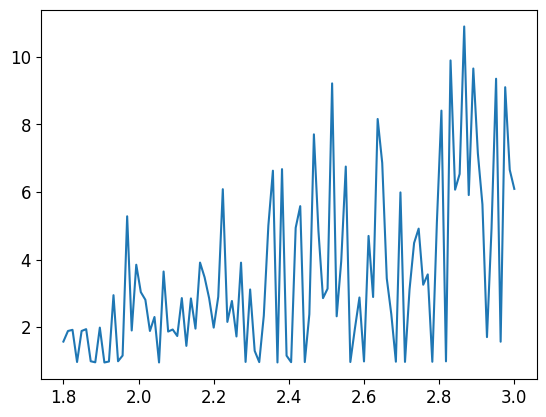

In [261]:
ranks = []
scales = np.linspace(1.8, 3.0, 100)
for scale in tqdm(scales):
    ranks.append(eval_rank('', scale)[0])
plt.plot(scales, ranks)

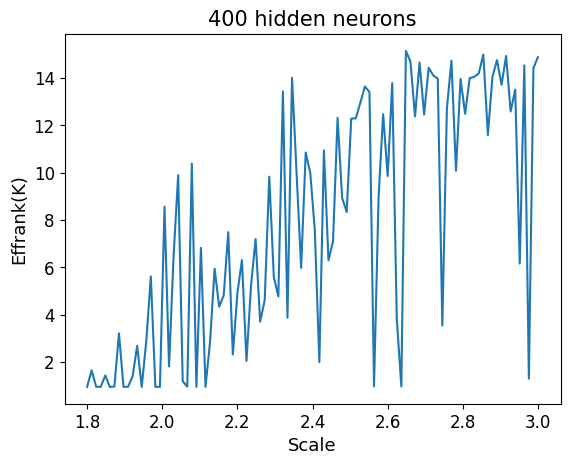

In [208]:
plt.plot(scales, ranks)
plt.xlabel('Scale')
plt.ylabel('Effrank(K)')
plt.title('400 hidden neurons')
plt.savefig('rank_v_scale_400.png')

In [277]:
ranks, varrats = [], []
scales = np.linspace(0.1, 4.0, 200)

import glob
files = glob.glob('mempro_tasks_rnn_100_units_over_scales/scale_*')

for file in tqdm(files):
    checkpoints = load_checkpoints(f'{file}/')[0]
    ranks.append([])
    varrats.append([])
    for ch in checkpoints[::10]:
        effrank, varrat, _ = eval_rank(ch)
        ranks[-1].append(effrank)
        varrats[-1].append(varrat)
ranks = np.array(ranks)
varrats = np.array(varrats)

100%|██████████| 199/199 [42:38<00:00, 12.86s/it]


In [283]:
np.save('ranks_rnn.npy', ranks)
np.save('varrats_rnn.npy', varrats)

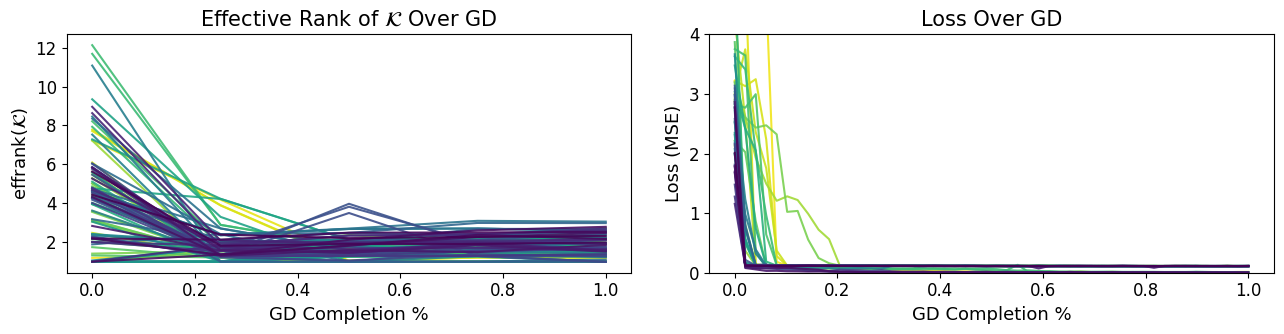

In [356]:
ranks_smooth = running_mean(ranks, axis = 0, window_size = 3)

plt.figure(figsize = (13, 3.5))
cmap = plt.get_cmap('viridis')

plt.subplot(1,2,1)
for i in range(ranks_smooth.shape[0]//2):
    plt.plot(np.linspace(0., 1., ranks.shape[1]), ranks_smooth[i], color = cmap(2*i / ranks_smooth.shape[0]), zorder = -i, alpha = .9)

plt.ylabel('effrank$(\\mathcal{K})$')
plt.xlabel('GD Completion %')
plt.title('Effective Rank of $\\mathcal{K}$ Over GD')


plt.subplot(1,2,2)
for i in range(0, losses_all.shape[0]//2):
    plt.plot(np.linspace(0., 1, losses_all.shape[1]), losses_all[i], color = cmap(2*i / losses_all.shape[0]), zorder = -i, alpha = .9)
plt.ylabel('Loss (MSE)')
plt.xlabel('GD Completion %')
plt.ylim(0, 4)
plt.title('Loss Over GD')

plt.tight_layout()

plt.savefig('rank_fig/effrank_over_GD.pdf')
plt.savefig('rank_fig/effrank_over_GD.png')
plt.show()

In [66]:
def kp_dim_at_checkpoint(ch, rnn = nn.GRU, hidden_size = 100):
    pop = evaluate_prop_op_with_scale(inputs, 1.0, ch, rnn = rnn, hidden_size)
    singular_vals = consensus_svd(pop.Us[:, -1], vals_only = True).detach().numpy()
    lyap = np.log(singular_vals) / pop.Us.shape[1]
    return kaplan_yorke_dim(lyap)

kp_dim = []
scales = np.linspace(0.1, 4.0, 200)

for file in tqdm(sweep_files):
    checkpoints = load_checkpoints(f'{file}/')[0]
    kp_dim.append([])
    for ch in checkpoints[::10]:
        kp_dim[-1].append(kp_dim_at_checkpoint(ch, rnn=nn.RNN, hidden_size = 256))
kp_dim = np.array(kp_dim)

  0%|          | 0/320 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([256, 3]) from checkpoint, the shape in current model is torch.Size([100, 3]).
	size mismatch for rnn.weight_hh_l0: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for rnn.bias_ih_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for rnn.bias_hh_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for Wout.weight: copying a param with shape torch.Size([3, 256]) from checkpoint, the shape in current model is torch.Size([3, 100]).

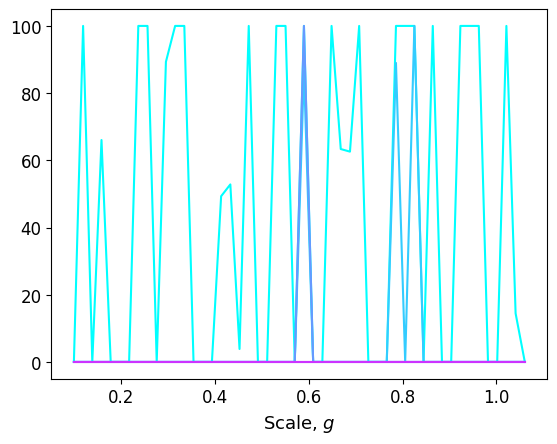

In [172]:
# dim_smooth = running_mean(kp_dim, axis = 0, window_size = 10)
dim_smooth = kp_dim
scales = np.linspace(0.1, 4.0, 200)[:-1]

cmap = plt.get_cmap('cool')
for i in range(dim_smooth.shape[1]):
    plt.plot(scales[:50], dim_smooth[:50, i], color = cmap(i / dim_smooth.shape[1]))
plt.xlabel('Scale, $g$')
plt.show()

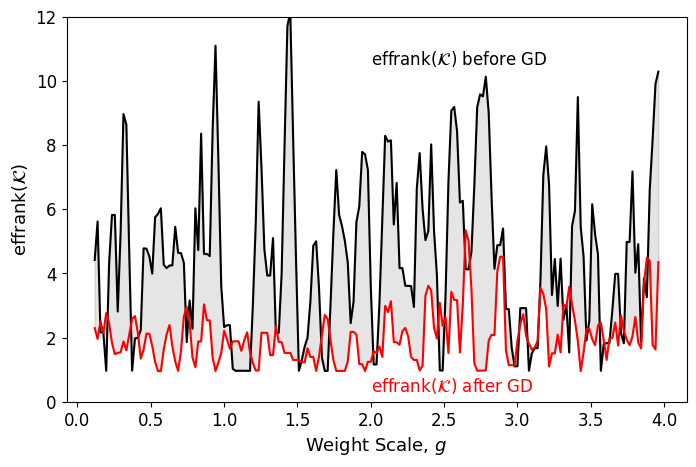

In [308]:
scales_smooth = running_mean(scales, 0, 3)[:-1]

plt.figure(figsize = (8,5))
plt.plot(scales_smooth, ranks_smooth[:, 0], c = 'black')
plt.plot(scales_smooth, ranks_smooth[:, -1], c = 'red')
plt.fill_between(scales_smooth, ranks_smooth[:, 0], ranks_smooth[:, -1], color = 'black', alpha = 0.1)
plt.text(2.0, 10.5, 'effrank($\\mathcal{K}$) before GD')
plt.text(2.0, 0.3, 'effrank($\\mathcal{K}$) after GD', color = 'red')
plt.ylim(0, 12)
plt.xlabel('Weight Scale, $g$')
plt.ylabel('effrank($\\mathcal{K}$)')
plt.savefig('rank_fig/bef_aft_effrank_K.pdf')
plt.savefig('rank_fig/bef_aft_effrank_K.png')

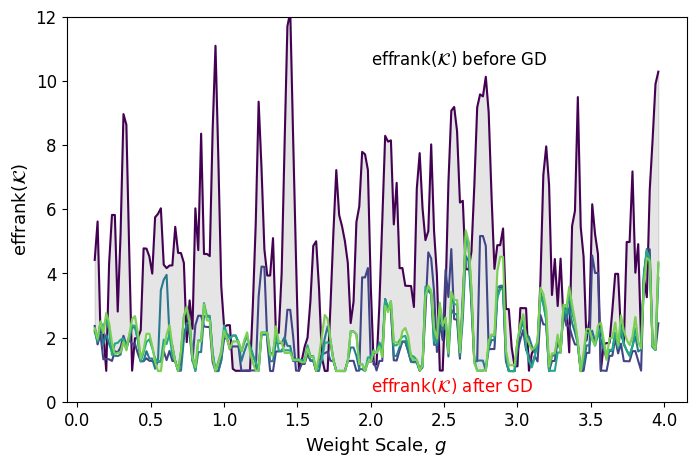

In [325]:
scales_smooth = running_mean(scales, 0, 3)[:-1]

plt.figure(figsize = (8,5))
for i in range(ranks_smooth.shape[1]):
    plt.plot(scales_smooth, ranks_smooth[:, i], c = cmap(i / ranks_smooth.shape[1]))
# plt.plot(scales_smooth, ranks_smooth[:, -1], c = 'red')
plt.fill_between(scales_smooth, ranks_smooth[:, 0], ranks_smooth[:, -1], color = 'black', alpha = 0.1)
plt.text(2.0, 10.5, 'effrank($\\mathcal{K}$) before GD')
plt.text(2.0, 0.3, 'effrank($\\mathcal{K}$) after GD', color = 'red')
plt.ylim(0, 12)
plt.xlabel('Weight Scale, $g$')
plt.ylabel('effrank($\\mathcal{K}$)')
plt.savefig('rank_fig/bef_aft_effrank_K.pdf')
plt.savefig('rank_fig/bef_aft_effrank_K.png')

In [317]:
losses_all = np.array(losses_all)
np.save('rank_fig/losses_all.npy', losses_all)

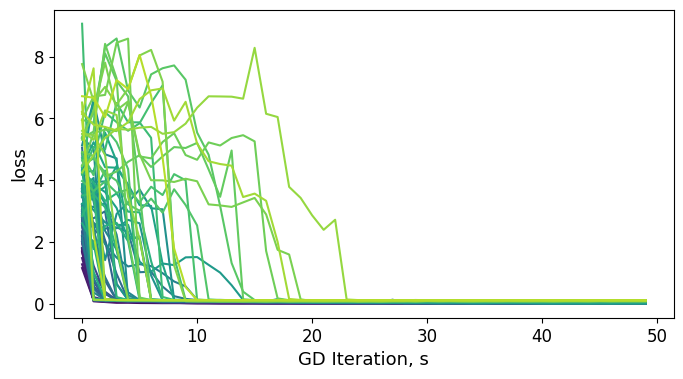

In [324]:
plt.figure(figsize = (8, 4))
cmap = plt.get_cmap('viridis')
for i in range(0, losses_all.shape[0]-10):
    plt.plot(losses_all[i], color = cmap(i / losses_all.shape[0]))
plt.ylabel('loss')
plt.xlabel('GD Iteration, s')
plt.savefig('rank_fig/losses.png')
plt.savefig('rank_fig/losses.pdf')
plt.show()

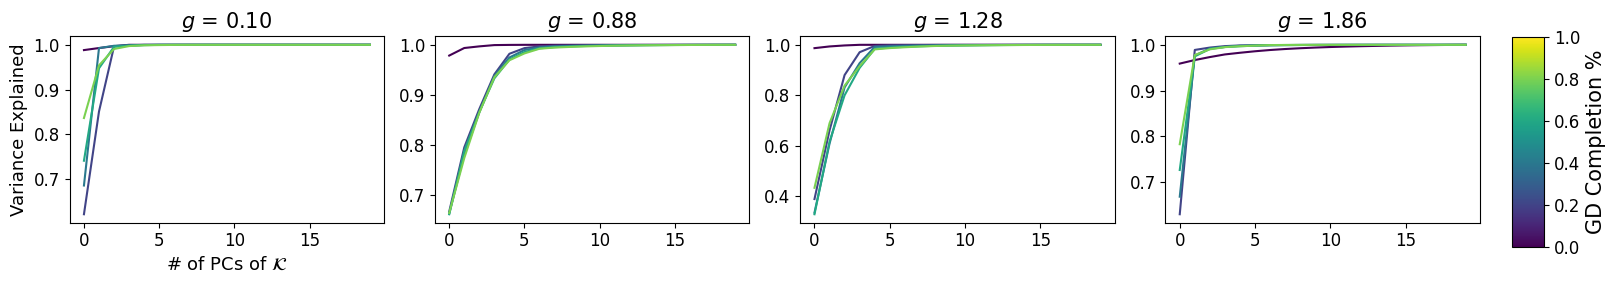

In [311]:
fig = plt.figure(figsize = (16, 3))
for idx, itr in enumerate([0, 40, 60, 90]):
    plt.subplot(1,4,1+idx)
    cmap = plt.get_cmap('viridis')
    for i in range(varrats.shape[1]):
        plt.plot(varrats[itr, i, :], color = cmap(i / (varrats.shape[1])))
    plt.title(f'$g$ = {scales[itr]:.2f}')

    if idx == 0:
        plt.xlabel('# of PCs of $\\mathcal{K}$')
        plt.ylabel('Variance Explained')

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.tight_layout()

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = 'viridis'), cax=cbar_ax)
cbar.set_label('GD Completion %', fontsize = 15)

plt.savefig('rank_fig/varrats_scale.pdf')
plt.savefig('rank_fig/varrats_scale.png')
plt.show()

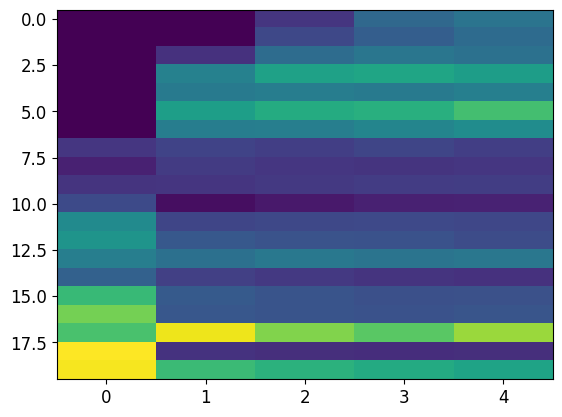

In [48]:
plt.imshow(ranks, aspect = 'auto')

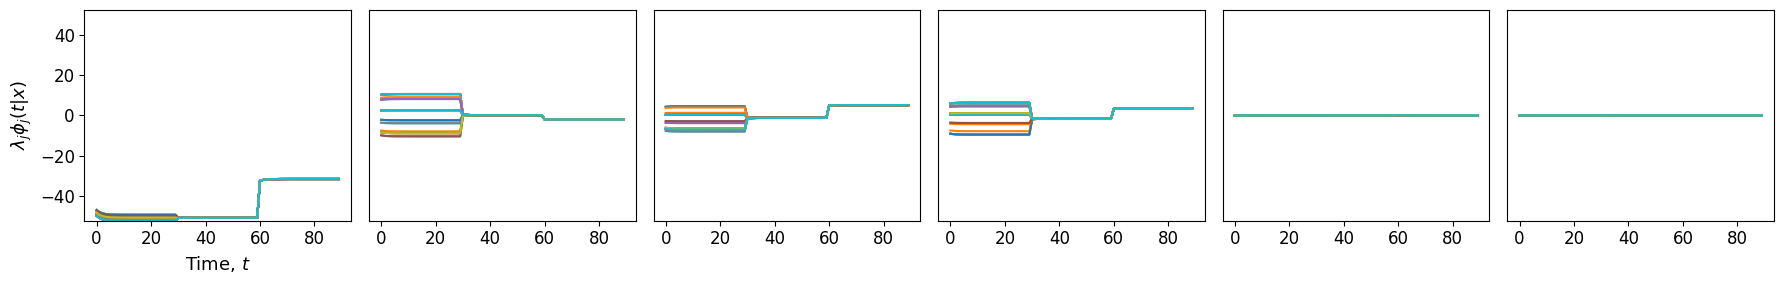

In [12]:
nfuns = 6
plt.figure(figsize = (3. * nfuns, 3))
# op = evaluate_kernel_op_with_scale(inputs, 1.0, checkpoint = 'mempro_tasks_gru_5000_units/repeat_0/checkpoints/checkpoint_0.pt')
op = evaluate_kernel_op_with_scale(inputs, 1.0, checkpoint = 'mempro_tasks_gru_5000_units/repeat_0/checkpoints/checkpoint_0.pt')
shape = Model()(inputs)[1].shape
shape = (*shape[:-1], 1)
pc_funs, singular_vals = op.svd(shape = shape, dtype = float)
pc_funs = pc_funs[..., 0] # squeeze
effdim, varrat = op.effrank(singular_vals, .95)

scaled_comps = singular_vals[:, None, None] * pc_funs
mn, mx = scaled_comps.min(), scaled_comps.max()
ymax = np.abs(scaled_comps).max()
for fun_idx in range(nfuns):
    plt.subplot(1, nfuns, 1 + fun_idx)
    plt.plot(scaled_comps[fun_idx, :30, :].T)
    plt.ylim(-ymax, ymax)
    if fun_idx != 0:
        plt.yticks([])
    else:
        plt.ylabel('$\\lambda_j \\phi_j(t|x)$')
        plt.xlabel('Time, $t$')

plt.tight_layout()
plt.savefig('eiguns_before.pdf')
plt.show()

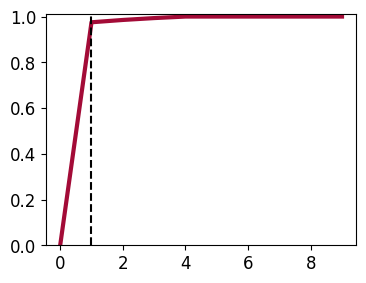

In [13]:
plt.figure(figsize = (4, 3))
plt.plot(np.concatenate([[0], varrat])[:10], color = "#A30B37", linewidth = 3.0)
plt.ylim(0., 1.01)
# plt.xlabel('# of PCs of $K$')
# plt.ylabel('Explained Variance Ratio')
plt.axvline(effdim, color = 'black', linestyle = 'dashed')
plt.savefig('varrat_before.pdf')

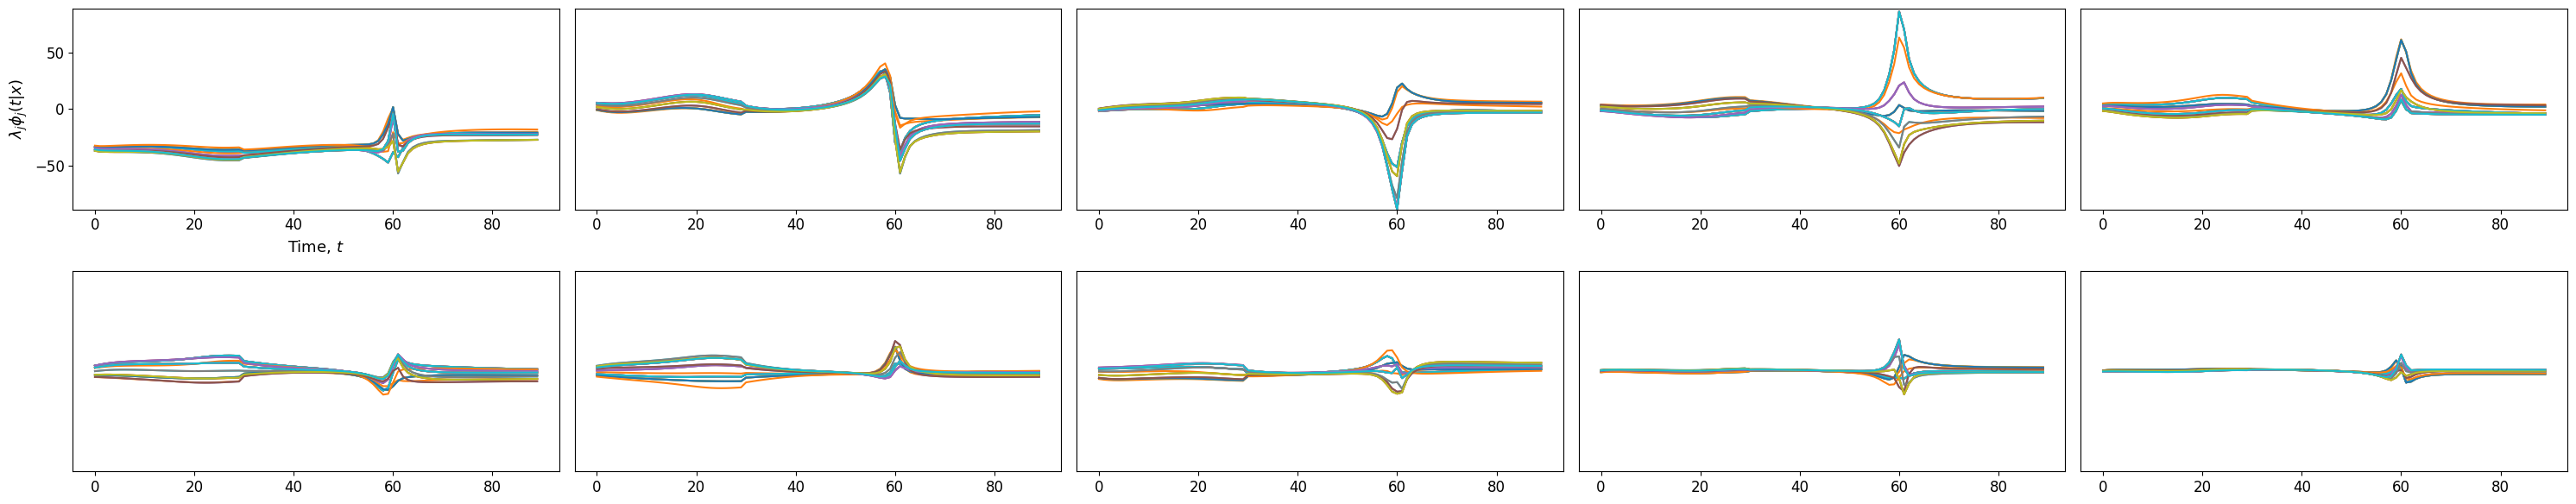

In [14]:
nfuns = 10
plt.figure(figsize = (3. * nfuns, 3 * 2))
op = evaluate_kernel_op_with_scale(inputs, 1.0, checkpoint = 'mempro_tasks_gru_5000_units/repeat_0/checkpoints/checkpoint_4900.pt')
shape = Model()(inputs)[1].shape
shape = (*shape[:-1], 1)
pc_funs, singular_vals = op.svd(shape = shape, dtype = float)
pc_funs = pc_funs[..., 0] # squeeze
effdim, varrat = op.effrank(singular_vals, .95)

scaled_comps = singular_vals[:, None, None] * pc_funs
mn, mx = scaled_comps.min(), scaled_comps.max()
ymax = np.abs(scaled_comps).max()
for fun_idx in range(nfuns):
    plt.subplot(2, nfuns // 2, 1 + fun_idx)
    plt.plot(scaled_comps[fun_idx, :30, :].T)
    plt.ylim(-ymax, ymax)
    if fun_idx != 0:
        plt.yticks([])
    else:
        plt.ylabel('$\\lambda_j \\phi_j(t|x)$')
        plt.xlabel('Time, $t$')

plt.tight_layout()
plt.savefig('eiguns_after.pdf')
plt.show()

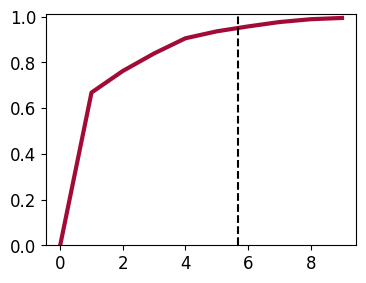

In [15]:
plt.figure(figsize = (4, 3))
plt.plot(np.concatenate([[0], varrat])[:10], color = "#A30B37", linewidth = 3.0)
plt.ylim(0., 1.01)
# plt.xlabel('# of PCs of $K$')
# plt.ylabel('Explained Variance Ratio')
plt.axvline(effdim, color = 'black', linestyle = 'dashed')
plt.savefig('varrat_after.pdf')

In [12]:
op = evaluate_kernel_op_with_scale(inputs, 1.0, checkpoint = 'mempro_tasks_gru_100_units/repeat_0/checkpoints/checkpoint_4900.pt')
shape = (*inputs.shape[:-1], 1)
op_sp = op.to_scipy(shape = (*inputs.shape[:-1], 1))
from scipy.sparse.linalg import eigsh
eigvals, eigfuns = eigsh(op_sp, k = 100)
eigvals, eigfuns = eigvals[::-1], eigfuns[::-1].T
eigfuns = eigfuns.reshape((-1, *shape))[..., 0]

KeyboardInterrupt: 

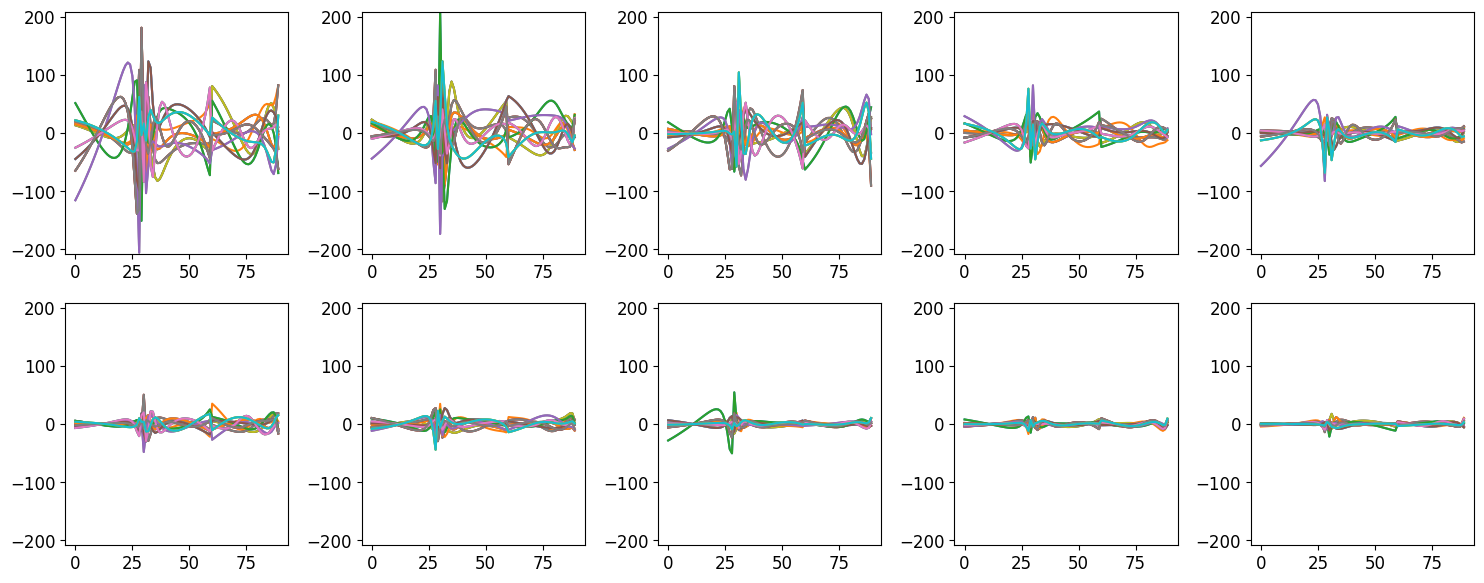

In [21]:
nfuns = 10
plt.figure(figsize = (3. * 5, 3 * 2))
ymax = np.abs(eigvals[:, None, None] * eigfuns).max()
for fun_idx in range(nfuns):
    plt.subplot(2, 5, 1 + fun_idx)
    plt.plot(eigvals[fun_idx] * eigfuns[fun_idx, :30, :].T)
    plt.ylim(-ymax, ymax)

plt.tight_layout()
plt.savefig('eiguns_after.pdf')
plt.show()

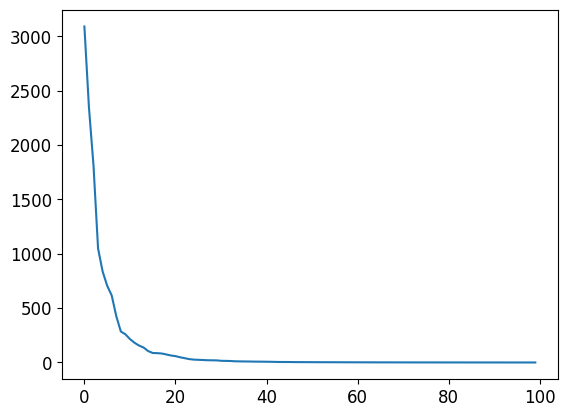

In [17]:
plt.plot(eigvals)

In [ ]:
plt.figure(figsize = (4, 3))
plt.plot(np.concatenate([[0], varrat])[:10], color = "#A30B37", linewidth = 3.0)
plt.ylim(0., 1.01)
# plt.xlabel('# of PCs of $K$')
# plt.ylabel('Explained Variance Ratio')
plt.savefig('varrat_after.pdf')

In [ ]:
plt.figure(figsize = (8, 4))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(30):
    plt.plot(inputs[i, :, :], color = colors[i % len(colors)])
    plt.xlabel('Time, t')
    plt.title('Task Inputs')

plt.savefig('inputs_mempro.pdf')
plt.show()

In [ ]:
plt.figure(figsize = (8, 4))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(30):
    plt.plot(targets[i, :, :], color = colors[i % len(colors)])
    plt.xlabel('Time, t')
    plt.title('Task Targets')

plt.savefig('targets_mempro.pdf')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
hidden = eval('mempro_tasks_gru_repeated/repeat_0/checkpoints/checkpoint_4900.pt')[1]

pca = PCA(3)
proj = pca.fit_transform(hidden.reshape((-1, hidden.shape[-1]))).reshape((*hidden.shape[:-1], 3))

for k in range(0, 360, 45):
    for j in range(0, 360, 45):
        plt.axes(projection='3d')
        # plt.axes()
        for i in range(30):
            plt.plot(*proj[i, :].T, linewidth = 2)
        plt.gca().view_init(k, j)
        plt.title(f'{k},{j}')
        plt.show()

In [ ]:
scales = np.linspace(0.1, 4., 200)
effranks = np.zeros_like(scales)
for idx, scale in enumerate(tqdm(scales)):
    op = evaluate_kernel_op_with_scale(inputs, scale)
    pc_funs, singular_vals = op.svd(shape = (*inputs.shape[:2], 1), dtype = float)
    pc_funs = pc_funs[..., 0] # squeeze
    effranks[idx], varrat = op.effdim(singular_vals, .95)
    plt.plot(varrat)
plt.show()

In [ ]:
plt.figure(figsize = (7, 4))
plt.plot(scales, effranks, color = "#A30B37", linewidth = 1.8)
plt.ylabel('Effrank$(K)$')
plt.xlabel('Weight Scale, $g$')

In [ ]:
scales = np.array([1.0, 2.0, 4.0])
plt.figure(figsize = (len(scales) * 3.3, 3.))
for idx, scale in enumerate(tqdm(scales)):
    op = evaluate_kernel_op_with_scale(inputs, scale)
    pc_funs, singular_vals = op.svd(shape = (*inputs.shape[:2], 1), dtype = float)
    pc_funs = pc_funs[..., 0] # squeeze
    effrank, varrat = op.effrank(singular_vals, .95)
    varrat_zero_based = np.concatenate([[0], np.array(varrat)])

    plt.subplot(1, len(scales), 1 + idx)
    plt.plot(varrat_zero_based, color = "#A30B37", linewidth = 1.9)
    plt.axvline(effrank, linestyle = 'dashed', color = 'black')
    plt.text(effrank+.5, .85, 'effrank($\\mathcal{K}$)', fontsize = 15)
    plt.title(f'$g = {scale:.1f}$', fontsize = 15)
    if idx == 0:
        plt.xlabel('# of Eigenfunctions Used', fontsize = 15)
        plt.ylabel('Cumulative Var. Ratio', fontsize = 15)
plt.tight_layout()
plt.savefig('K_effrank_v_scale.pdf')
plt.show()

In [ ]:
scales = np.array([1.0, 1.5, 3.5, 4.5])
pc_funs_all = []
plt.figure(figsize = (len(scales) * 3., 1.5 * 5))
for idx, scale in enumerate(tqdm(scales)):
    op = evaluate_kernel_op_with_scale(inputs, scale)
    pc_funs, singular_vals = op.svd(shape = (*inputs.shape[:2], 1), dtype = float)
    pc_funs = pc_funs[..., 0] # squeeze
    effdim, varrat = op.effdim(singular_vals, .95)

    pc_funs_all.append(pc_funs)
    scaled_comps = singular_vals[:, None, None] * pc_funs
    mn, mx = scaled_comps.min(), scaled_comps.max()
    for fun_idx in range(5):
        plt.subplot(5, len(scales), 1 + idx + len(scales) * fun_idx)
        plt.plot(scaled_comps[fun_idx, :30, :].T)
        plt.ylim(1.05*mn, 1.05*mx)
        if fun_idx != 4:
            plt.xticks([])

        if idx != 0:
            plt.yticks([])
    
pc_funs_all = np.stack(pc_funs_all)
plt.tight_layout()
plt.show()